Imports

In [1]:
import os
import sys
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
utils_dir = os.path.join(parent_dir, "src", "utils")
sys.path.append(utils_dir)

In [2]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from IPython.display import display, HTML
from find_tickets_holder import search_tickers
import pickle
import yfinance as yf
import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from nombre_total_titres import get_nombre_total_titre
#from processing_n_interpolate import ProcessingInterpolate
from score_calculator import score_calculator

Creation Dataframe

In [3]:
amf_short_csv_path = os.path.join("..", "data", "processed", "AMF_short_data.csv")
df = pd.read_csv(amf_short_csv_path, delimiter=',')
df

POSITION HOLDER\r\nDETENTEUR DE LA POSITION  \
0                MILLENNIUM CAPITAL PARTNERS LLP   
1                        CAPITAL FUND MANAGEMENT   
2              MELQART ASSET MANAGEMENT (UK) LTD   
3                     CAPITAL FUND MANAGEMENT SA   
4                MILLENNIUM CAPITAL PARTNERS LLP   
...                                          ...   
1540             MILLENNIUM CAPITAL PARTNERS LLP   
1541                SCOPIA CAPITAL MANAGEMENT LP   
1542                    GSA CAPITAL PARTNERS LLP   
1543                   CLEARANCE CAPITAL LIMITED   
1544                SCOPIA CAPITAL MANAGEMENT LP   

     NOM DE L’ÉMETTEUR\r\nNAME OF THE ISSUER          ISIN  \
0                                      REXEL  FR0010451203   
1                                        CGG  FR0013181864   
2                  CASINO GUICHARD-PERRACHON  FR0000125585   
3                                        CGG  FR0013181864   
4                                      REXEL  FR0010451203   
...                                      ...           ...   
1540                                   REXEL  FR0010451203   
1541                                  RALLYE  FR0000060618   
1542                           MC PHY ENERGY  FR0011742329   
1543                                 CARMILA  FR0010828137   
1544                                  RALLYE  FR0000060618   

      POSITION COURTE NETTE DETENUE EN %\r\nNET SHORT POSITION SIZE IN PERCENTAGE  \
0                                                  0.85                             
1                                                  0.78                             
2                                                  1.46                             
3                                                  0.63                             
4                                                  1.30                             
...                                                 ...                             
1540                                               1.64                             
1541                                               0.52                             
1542                                               0.52                             
1543                                               0.47                             
1544                                               0.91                             

     DATE DE POSITION (AAAA-MM-JJ)\r\nPOSITION DATE (YYYY-MM-DD)  
0                                            2022-02-28           
1                                            2022-11-21           
2                                            2023-06-07           
3                                            2021-06-18           
4                                            2022-08-02           
...                                                 ...           
1540                                         2022-09-08           
1541                                         2018-10-22           
1542                                         2023-10-06           
1543                                         2020-06-11           
1544                                         2019-03-14           

[1545 rows x 5 columns]

Defining a function to display scrollable dataframes

In [4]:
def scroll_visu_dataframe(df, rest_index= False): 
    if rest_index : 
        y = df.reset_index()  # Cela ajoute l'index comme colonne(s) au DataFrame
    else : 
        y = df

    # Mettre à jour les headers pour inclure les noms des colonnes d'index
    headers = ['Index'] + list(y.columns)  # Ajoutez 'Index' ou le nom réel des niveaux d'index si nécessaire

    # Ajuster les valeurs pour inclure les index
    cells_values = [y.index] + [y[col] for col in y.columns]

    fig = go.Figure(data=[go.Table(
        header=dict(values=headers,
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=cells_values,  # Mise à jour pour inclure l'index
                fill_color='lavender',
                align='left'))
    ])

    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor='rgba(0,0,0,0)',  
        plot_bgcolor='rgba(0,0,0,0)',
    )

    fig.show()

Changing column names for something easier and deleting line breaks

In [5]:
new_names = {
    'POSITION HOLDER\r\nDETENTEUR DE LA POSITION': 'Position holder',
    'NOM DE L’ÉMETTEUR\r\nNAME OF THE ISSUER': 'Name of the issuer',
    'ISIN': 'ISIN',
    'POSITION COURTE NETTE DETENUE EN %\r\nNET SHORT POSITION SIZE IN PERCENTAGE': 'Net short position in %',
    'DATE DE POSITION (AAAA-MM-JJ)\r\nPOSITION DATE (YYYY-MM-DD)': 'Position date YYYY-MM-DD'
}

df.rename(columns=new_names, inplace=True)
df['Position holder'] = df['Position holder'].str.replace(r'\r?\n', ' ', regex=True)
df['Name of the issuer'] = df['Name of the issuer'].str.replace(r'\r?\n', ' ', regex=True)
scroll_visu_dataframe(df)

Nombre d'apparition d'un détenteur/émetteur et noms des détenteur/émetteur

In [6]:
def appearance_counter(who="Holder") :
    # arg : "Holder" or "Emitter"
    colonne = df.columns[(who=='Emiter')*1]
    nombre_uniques = df[colonne].nunique()
    elements_uniques = df[colonne].unique()
    if who == "Emiter" :
        # Case where we search emiter, holder empty and emiter full

        # nb ; holder ; emiter
        return(nombre_uniques, [], df[colonne].unique())
    # Case where we search emiter, holder full and emiter empty

    # nb ; holder ; emiter
    return(nombre_uniques, df[colonne].unique(), [])

In [7]:
nb_unique_el, holder, emetteurs = appearance_counter('Holder')
nb_unique_el, holder, emetteurs

(154,
 array(['MILLENNIUM CAPITAL PARTNERS LLP', 'CAPITAL FUND MANAGEMENT',
        'MELQART ASSET MANAGEMENT (UK) LTD', 'CAPITAL FUND MANAGEMENT SA',
        'MARSHALL WACE LLP', 'JPMORGAN ASSET MANAGEMENT (UK) LIMITED',
        'PUBLIC EQUITY PARTNERS MANAGEMENT, L.P.',
        'OCEANWOOD CAPITAL MANAGEMENT LIMITED', 'GSA CAPITAL PARTNERS LLP',
        'CITADEL ADVISORS EUROPE LIMITED', 'SYQUANT CAPITAL',
        'QUBE RESEARCH & TECHNOLOGIES LIMITED',
        'ASTARIS CAPITAL MANAGEMENT LLP', 'B&G MASTER FUND PLC',
        'LMR PARTNERS LLP', 'GLADSTONE CAPITAL MANAGEMENT LLP',
        'AKO CAPITAL LLP', 'MILLENNIUM INTERNATIONAL MANAGEMENT LP',
        'ADELPHI CAPITAL LLP', 'HUTCHIN HILL CAPITAL, LP',
        'CITADEL EUROPE LLP', 'BLACKROCK INVESTMENT MANAGEMENT UK LIMITED',
        'BLACKROCK INVESTMENT MANAGEMENT (UK) LIMITED',
        'MACKAY SHIELDS LLC', 'HBK INVESTMENTS L.P.',
        'BLACKROCK INSTITUTIONAL TRUST COMPANY NATIONAL ASSOCIATION',
        'AIRAIN LTD', 'CITAD

This code don't work when you have emmitter in the last cell

In [8]:
dico_tickers_path = os.path.join("..","data", "unclassed", "dictionnaire_tikers.pkl")

if not os.path.exists(dico_tickers_path):

    dic_tikers = dict()
    for emetteur in emetteurs:
        search_tickers(holder, dic_tikers, f'{holder} yahoo')

    with open(dico_tickers_path, "wb") as fichier:
                # Notez que vous devez convertir dic_tickers en un dictionnaire normal pour le sauvegarder avec pickle
                pickle.dump(dict(dic_tikers), fichier)

else : 
    with open(dico_tickers_path,"rb") as fichier :
        dic_tikers = pickle.load(fichier)


In [9]:
#TODO chercher les Ticker de cette liste 

ticker_dic = dict()
fail_dic = []
for ex in dic_tikers : 

    test = dic_tikers[ex]
    v1 = test.split('.PA')
    v2 = test.split('(')

    if len(v1) > 1 : 
        if len(v2) > 1 : 
            res = v1[0].split('(')[-1]
            res = f'{res}.PA'
            ticker_dic[ex] = res
        else : 
            res = v1[0].split(' ')[-1]
            res = f'{res}.PA'
            ticker_dic[ex] = res
    else : 
        res = ""
        fail_dic.append(ex)

# Tickers fail : fail_dic 
print(fail_dic)

['BOURBON', 'KORIAN', 'PEUGEOT S.A.', 'FAURECIA', 'BOURBON CORPORATION', 'NAVYA', 'DBV TECHNOLOGIES', 'EUROPCAR MOBILITY GROUP', 'AKKA TECHNOLOGIES', 'ERYTECH PHARMA', 'TECHNIPFMC PLC', 'NEOPOST', 'INGENICO', 'SUEZ', "COMPAGNIE INDUSTRIELLE ET FINANCIERE D'ENTREPRISES", 'ILIAD', 'ALBIOMA']


In [10]:
ticker_dic['PEUGEOT S.A.'] = 'PEUG.PA'
ticker_dic['DBV TECHNOLOGIES'] = 'DBV.PA'

fail_dic.remove('PEUGEOT S.A.')
fail_dic.remove('DBV TECHNOLOGIES')

On trie le dataframe par position holder et on affiche les investissements pour chaque emetteur

In [11]:
# Trier le DataFrame par 'Position holder'
dg = df.groupby(['Position holder','Name of the issuer'],group_keys=True)[[
       'Net short position in %',
       'Position date YYYY-MM-DD']].apply(lambda x: x)

# Étape 1: Convertir la colonne de date en datetime
dg['Position date YYYY-MM-DD'] = pd.to_datetime(dg['Position date YYYY-MM-DD'])

# Étape 2: Trier le DataFrame par la colonne de date
df_sorted = dg.sort_values(by='Position date YYYY-MM-DD')


df_sorted = df_sorted.reset_index(level=2, drop=True)

df_sorted.set_index('Position date YYYY-MM-DD', append=True, inplace=True)
df_sorted.head(10)
#scroll_visu_dataframe(df_sorted,True)

Net short position in %
Position holder                        Name of the issuer                                 Position date YYYY-MM-DD                         
BALYASNY ASSET MANAGEMENT, L.P.        L'OREAL                                            2013-01-29                                   0.50
                                                                                          2013-01-30                                   0.38
BLACKWELL PARTNERS, LLC                ARTPRICE.COM                                       2013-03-19                                   0.82
CADIAN CAPITAL MANAGEMENT, LLC         COMPAGNIE INDUSTRIELLE ET FINANCIERE D'ENTREPRISES 2013-04-22                                   2.33
SUSQUEHANNA INTERNATIONAL GROUP LTD    FNAC SA                                            2013-06-21                                   0.59
                                       GROUPE FNAC                                        2013-08-05                                   0.81
QUANTITATIVE MANAGEMENT ASSOCIATES LLC NEXANS                                             2013-10-17                                   1.00
HUTCHIN HILL CAPITAL, LP               SOLOCAL GROUP                                      2014-05-16                                   0.64
OXFORD ASSET MANAGEMENT LLP            BOLLORE                                            2014-12-01                                   1.10
                                                                                          2014-12-03                                   0.01

Pour chaque Holder/Emiter affiche le nombre d'opppération

In [12]:
def operation_counter(who="Holder") :
    # arg : "Holder" or "Emitter"
    colonne = df.columns[(who=='Emiter')*1]
    nombre_apparitions = df[colonne].value_counts()
    nombre_apparitions = pd.DataFrame(nombre_apparitions)
    return nombre_apparitions

In [13]:
nb_apparitions = operation_counter("Emiter")

In [14]:
scroll_visu_dataframe(nb_apparitions)

In [15]:
def visualiser_investissments(holder, df,visu = False): 
    cgg_rows= df.loc[
    (df.index.get_level_values(0) == holder) 
    
    ]
    if visu : 
        cgg_rows.index

    scroll_visu_dataframe(cgg_rows,rest_index=True)


def visualiser_investissment(holder,emitter, df,visu = True): 
    cgg_rows= df.loc[
    (df.index.get_level_values(0) == holder) &
    (df.index.get_level_values(1) == emitter)
    
    ]

    start_date = str(cgg_rows.index[0][-1]).split(' ')[0]
    #print('Date de début :')
    #print(start_date)
    #print()
    if visu : 
        scroll_visu_dataframe(cgg_rows,rest_index=True)
        print(cgg_rows)
    return cgg_rows , start_date



def visuel_action_investissement(start_date,cgg_rows,ticker):


    end_date = datetime.datetime.now().strftime('%Y-%m-%d')  
    # Télécharger les données du marché
    data = yf.download(ticker, start=start_date, end=end_date)


    def standardize(series):
        return (series - series.mean()) / series.std()

    # Standardiser les séries de données
    values_your_df_standardized = standardize(cgg_rows[cgg_rows.columns[0]])
    close_values_data_df_standardized = standardize(data['Close'])

    # Extraire les dates pour le tracé
    dates_your_df = pd.to_datetime([idx[2] for idx in cgg_rows.index])
    dates_data_df = data.index

    # Création du graphique
    plt.figure(figsize=(14, 7))

    # Tracer les séries de données standardisées
    plt.plot(dates_your_df, values_your_df_standardized, label='Votre Colonne (Standardisée)', marker='o', linestyle='-')
    plt.plot(dates_data_df, close_values_data_df_standardized, label='Valeurs de Clôture (Standardisées)', marker='', linestyle='--')

    # Configuration du graphique
    plt.title('Comparaison des Variations (Standardisées)')
    plt.xlabel('Date')
    plt.ylabel('Valeur Standardisée')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()
    return data



def visuel_action_invest_min_max(start_date, cgg_rows, ticker):
    
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')  
    # Télécharger les données du marché
    data = yf.download(ticker, start=start_date, end=end_date)
    #print(data )
    # Fonction pour normaliser une série de données en utilisant MinMaxScaler
    def normalize_min_max(series):
        scaler = MinMaxScaler(feature_range=(0, 1))
        series_scaled = scaler.fit_transform(series.values.reshape(-1,1)).flatten()  # Reshape pour scaler et re-flatten après
        return series_scaled

    # Normaliser les séries de données
    values_your_df_normalized = normalize_min_max(cgg_rows[cgg_rows.columns[0]])
    close_values_data_df_normalized = normalize_min_max(data['Close'])

    # Extraire les dates pour le tracé
    dates_your_df = pd.to_datetime([idx[2] for idx in cgg_rows.index])
    dates_data_df = data.index

    # Création du graphique
    plt.figure(figsize=(14, 7))

    # Tracer les séries de données normalisées
    plt.plot(dates_your_df, values_your_df_normalized, label='Votre Colonne (Normalisée)', marker='o', linestyle='-')
    plt.plot(dates_data_df, close_values_data_df_normalized, label='Valeurs de Clôture (Normalisées)', marker='', linestyle='--')

    # Configuration du graphique
    plt.title('Comparaison des Variations (Normalisées)')
    plt.xlabel('Date')
    plt.ylabel('Valeur Normalisée')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

    return data

def get_share(start_date, ticker) :
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    share_performance = yf.download(ticker, start=start_date, end=end_date)
    columns_to_data = {"Share Performance" : share_performance["Close"]}
    return pd.DataFrame.from_dict(columns_to_data)

def get_shares(start_date, ticker):
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    share_performance = yf.download(ticker, start=start_date, end=end_date)
    return share_performance


def benef(data,cgg_rows,total_titre) : 

    
    holding = np.array(cgg_rows[cgg_rows.columns[0]])/100

    initial_value = holding[0]
    variation_holding =  holding[1:] - holding[:-1]

    dates = [index[2] for index in cgg_rows.index ]
    value_action = [data['Close'][str(date).split(' ')[0]] for date in  dates]
    #print(value_action[0])
    
    achat_init = value_action[0]  * total_titre * initial_value
    prix_achat = np.array(value_action) * total_titre * holding
    delta_achat = np.array(value_action[1:]) * total_titre * variation_holding
    #print(delta_achat)
    vente = np.array([achat_init + np.sum(delta_achat[:k]) for k in range(len(delta_achat)+1)])
    benef_par_jour = vente - prix_achat 


    dates_your_df = pd.to_datetime([idx[2] for idx in cgg_rows.index])

    # Création du graphique
    plt.figure(figsize=(14, 7))

    # Tracer les séries de données normalisées
    plt.plot(dates_your_df, benef_par_jour, label='benef', marker='o', linestyle='-')


    # Configuration du graphique
    plt.title('benef ')
    plt.xlabel('Date')
    plt.ylabel('Valeur euros')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()



def benef_continue(data,cgg_rows,total_titre,from_last_position_to_end = False): 
    holding = np.array(cgg_rows[cgg_rows.columns[0]])/100

    dates = [index[2] for index in cgg_rows.index ]
    dates = np.array(dates)
    delta_date = dates[1:] - dates[:-1]
    delta_date_int = np.array([ delta.days for delta in delta_date ])

    date_ini = dates[0]
    date_final = dates[-1]

    holdings = []
    for k in range(len(holding)-1):
        holdings +=[holding[k] for _ in range(delta_date_int[k]) ]
    holdings = np.array(holdings+ [holdings[-1]]*(1 + from_last_position_to_end*(data.index[-1] - date_final).days))
    holding = holdings


    delta = date_final-date_ini
    dates = [dates[0]+ pd.Timedelta(days=k) for k in range(delta.days+1) ] + [date_final + pd.Timedelta(days=k) for k in range((data.index[-1] - date_final).days) ]*(from_last_position_to_end)


    initial_value = holding[0]
    variation_holding =  holding[1:] - holding[:-1]


    value_action= [data['Close'][str(dates[0]).split(' ')[0]]]

    for date in  dates[1:] : 
        try:
            value_action+= [data['Close'][str(date).split(' ')[0]]]
        except Exception as e:
        #print("ok")
            value_action+= [value_action[-1]]

    value_action

    achat_init = value_action[0]  * total_titre * initial_value
    prix_achat = np.array(value_action) * total_titre * holding
    delta_achat = np.array(value_action[1:]) * total_titre * variation_holding
    #print(delta_achat)
    vente = np.array([achat_init + np.sum(delta_achat[:k]) for k in range(len(delta_achat)+1)])
    benef_par_jour = vente - prix_achat 

    dates_your_df = pd.to_datetime(dates)

    # Création du graphique
    plt.figure(figsize=(14, 7))

    # Tracer les séries de données normalisées
    plt.plot(dates_your_df, benef_par_jour, label='benef', linestyle='--')


    # Configuration du graphique
    plt.title('benef continue')
    plt.xlabel('Date')
    plt.ylabel('Valeur euros')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()
    return benef_par_jour



# Vérifier la pertinence pour chaque nouvelles positions en projetant sur un certain nombre de jour sa valeur possible de rachat 

def pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows)  :
    # cgg rows is the df with holder, emitter, date ordered and the differents positions of the holder on the emitter in %
    holding = np.array(cgg_rows[cgg_rows.columns[0]])/100 # divided by 100 because it's in %

    # column 2 of the df is the date
    dates = [index[2] for index in cgg_rows.index ]
    
    # data contains the price of the actions at any time 
    value_action = [data['Close'][pd.to_datetime(date)] for date in  dates]

    # We take a group of dates to make a local average then
    dates_f = np.array([ [date + pd.Timedelta(days=k) for k in range(add_how_many_days+1)] for date in dates  ])


    initial_value = holding[0]
    # List of position variation
    variation_holding =  holding[1:] - holding[:-1]

    # First sell
    vente_init = value_action[0]  * total_titre * initial_value
    # Variation between each position
    delta_achat = np.array(value_action[1:]) * total_titre * variation_holding
    
    # Value of the differents positions throught the time
    value_short_position = np.array([vente_init + np.sum(delta_achat[:k]) for k in range(len(delta_achat)+1)])

    # Create a list of size "add_how_many_days+1" for each sell, same for holding
    ventes_f = np.array([[vente]*(add_how_many_days+1) for vente in value_short_position ])
    holding_f = np.array([[hold]*(add_how_many_days+1) for hold in holding ])


    value_action = []
    for date in  dates_f :
        # add the first close value
        add = [data['Close'][pd.to_datetime(date[0])]]
        for dat in date[1:] :
            # for each date we try to find the close value
            try:
                add+= [data['Close'][pd.to_datetime(dat)]]
            # if we don't find a close value corresponding to the date, we take the last one
            except Exception as e:
                #print("ok")
                add+= [add[-1]]
        value_action += [add]

    
    value_action = np.array(value_action)
    prix_achat =value_action * total_titre * holding_f
    benef_par_jour = ventes_f - prix_achat

    plt.figure(figsize=(14, 7))

    # Création du graphique
    plt.figure(figsize=(14, 7))

    for k in range(len(dates_f)) : 
        dates_your_df =  pd.to_datetime(dates_f[k])

        plt.plot(dates_your_df, benef_par_jour[k], label='benef', linestyle='--')


    # Configuration du graphique
    plt.title('benef ')
    plt.xlabel('Date')
    plt.ylabel('Valeur euros')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

    pourcentage_de_bon_choix = np.mean(benef_par_jour, axis=1)

    mask = pourcentage_de_bon_choix > 0 

    print(f' % de bonne position sur une projection de {add_how_many_days} jours')
    print(f'{len(pourcentage_de_bon_choix[mask])*100/len(pourcentage_de_bon_choix)} %')



# BLACKROCK INVESTMENT MANAGEMENT UK LIMITED

In [16]:
Holder = "BLACKROCK INVESTMENT MANAGEMENT UK LIMITED"
visualiser_investissments(Holder, df_sorted)

### CASINO GUICHARD-PERRACHON

In [17]:
visualiser_investissment("BLACKROCK INVESTMENT MANAGEMENT UK LIMITED", 'CASINO GUICHARD-PERRACHON',df_sorted,False)

(                                                                                               Net short position in %
 Position holder                            Name of the issuer        Position date YYYY-MM-DD                         
 BLACKROCK INVESTMENT MANAGEMENT UK LIMITED CASINO GUICHARD-PERRACHON 2017-10-02                                   0.50
                                                                      2017-10-11                                   0.63
                                                                      2017-10-13                                   0.71
                                                                      2017-11-03                                   0.80
                                                                      2017-11-16                                   0.79
                                                                      2017-12-13                                   0.69
                                        

[*********************100%%**********************]  1 of 1 completed


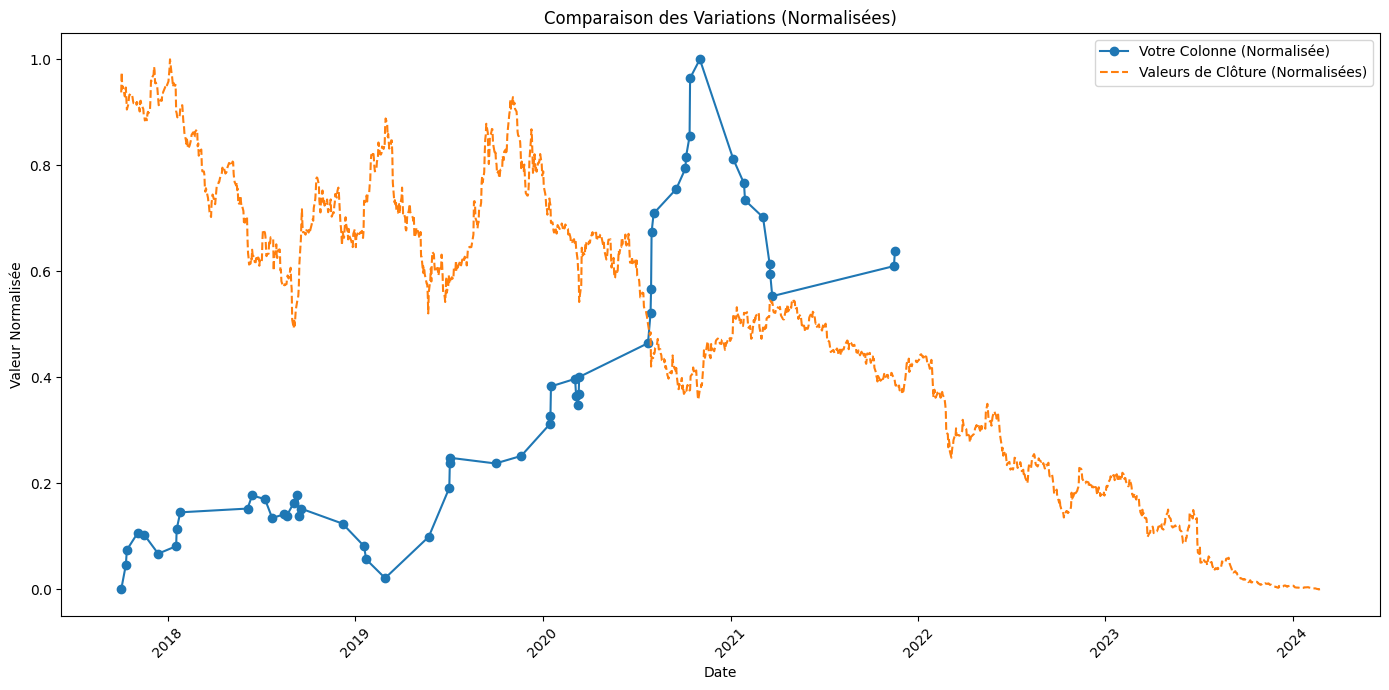

[*********************100%%**********************]  1 of 1 completed


            Share Performance
Date                         
2017-10-02          50.000000
2017-10-03          52.000000
2017-10-04          50.380001
2017-10-05          50.590000
2017-10-06          50.400002
...                       ...
2024-02-19           0.430000
2024-02-20           0.399200
2024-02-21           0.426400
2024-02-22           0.410400
2024-02-23           0.415200

[1640 rows x 1 columns]


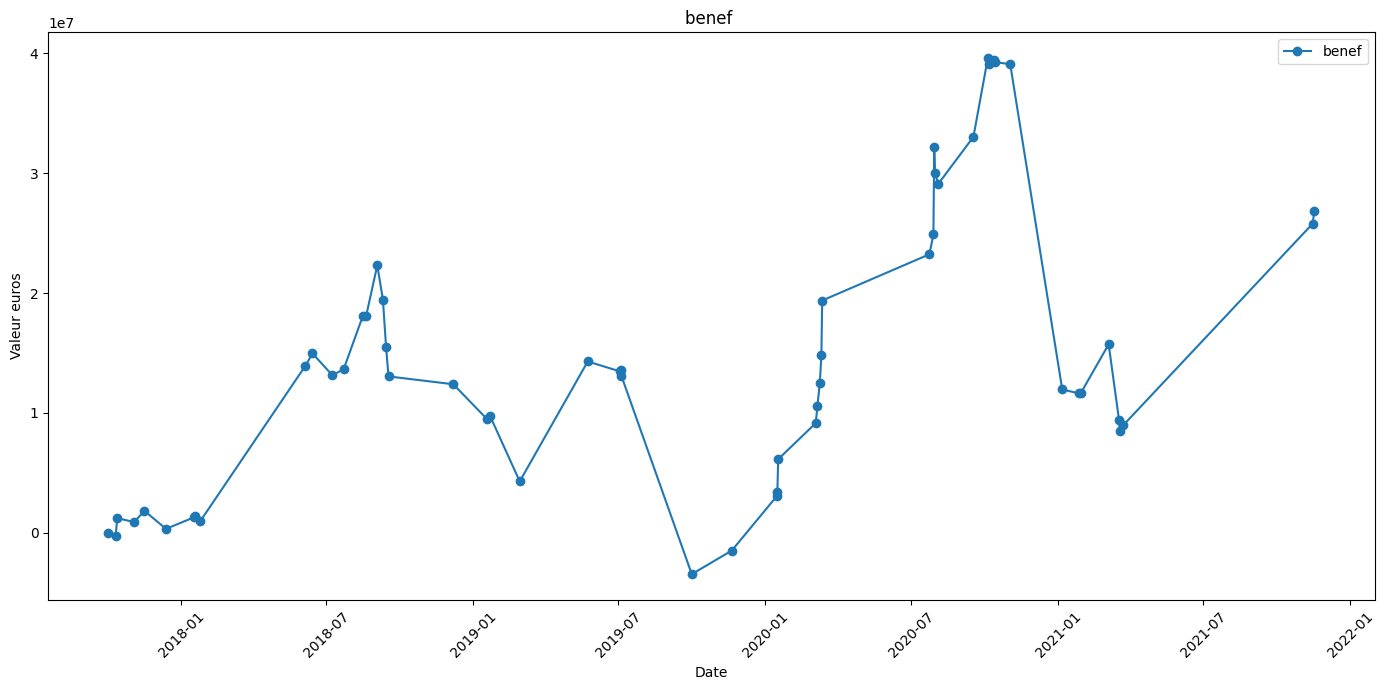

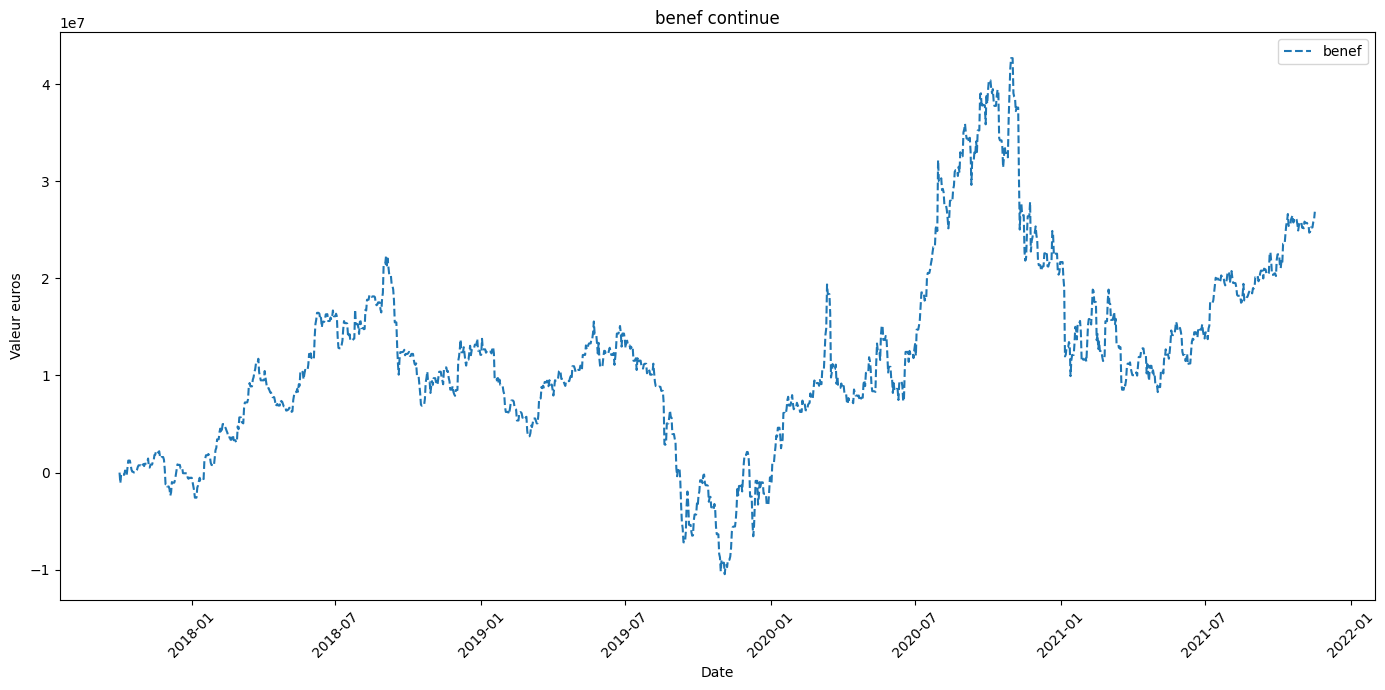

<Figure size 1400x700 with 0 Axes>

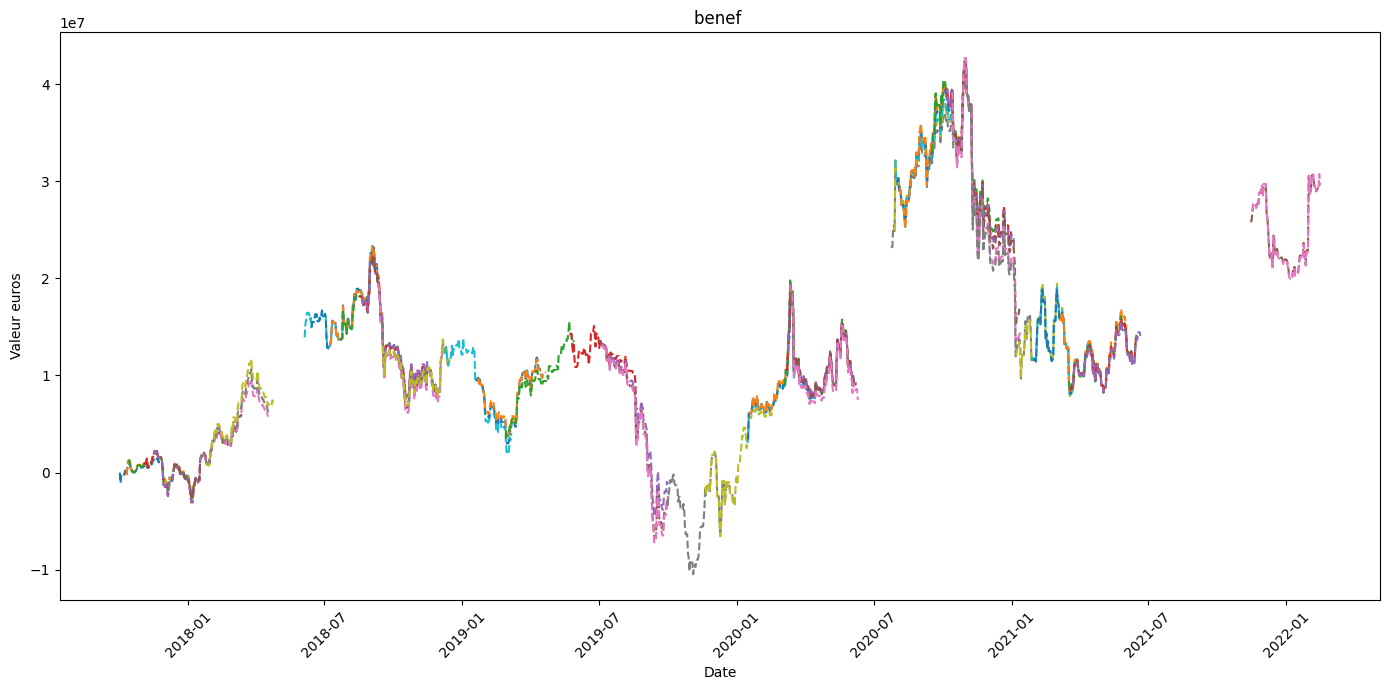

 % de bonne position sur une projection de 90 jours
98.24561403508773 %


In [18]:
emetteur =  'CASINO GUICHARD-PERRACHON'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    print(get_share(start_date,ticker))
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef(data,cgg_rows,total_titre)
    benef_continue(data,cgg_rows,total_titre)

    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows)

# CITADEL ADVISORS EUROPE LIMITED

In [19]:
Holder = "CITADEL ADVISORS EUROPE LIMITED"
visualiser_investissments(Holder, df_sorted)

### AIR FRANCE-KLM

[*********************100%%**********************]  1 of 1 completed


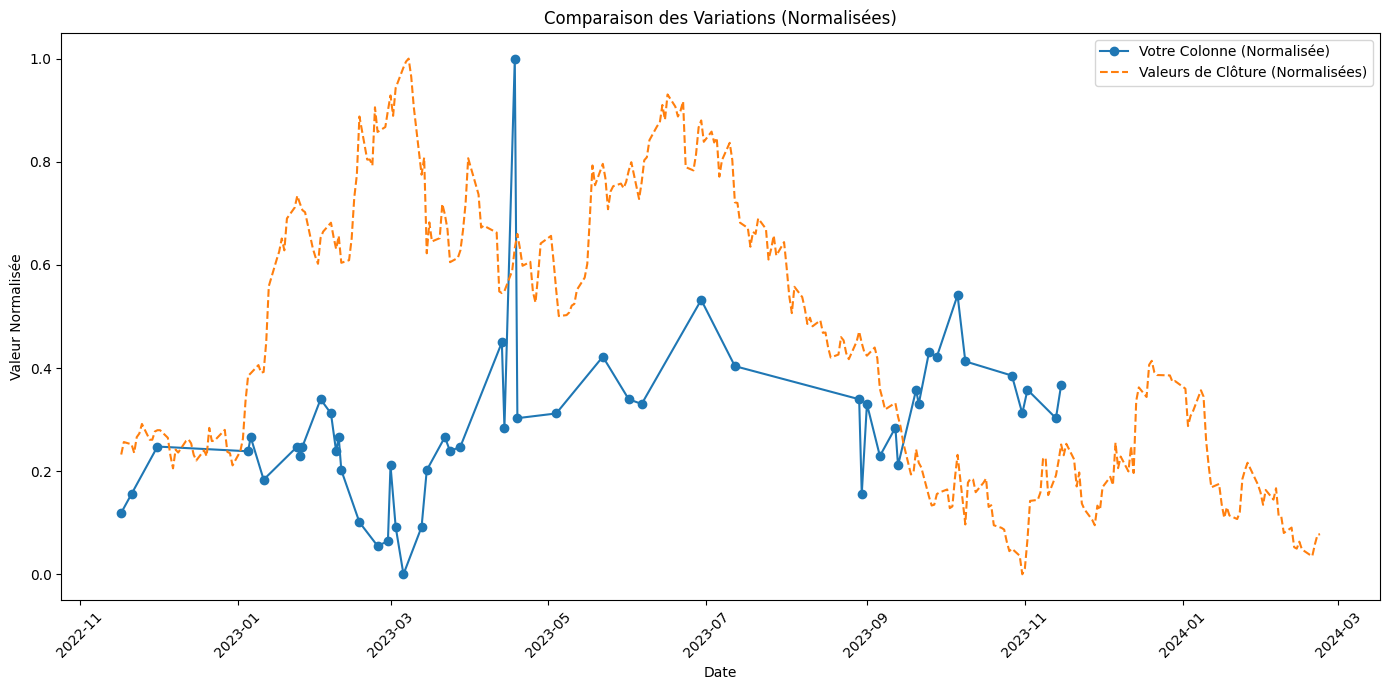

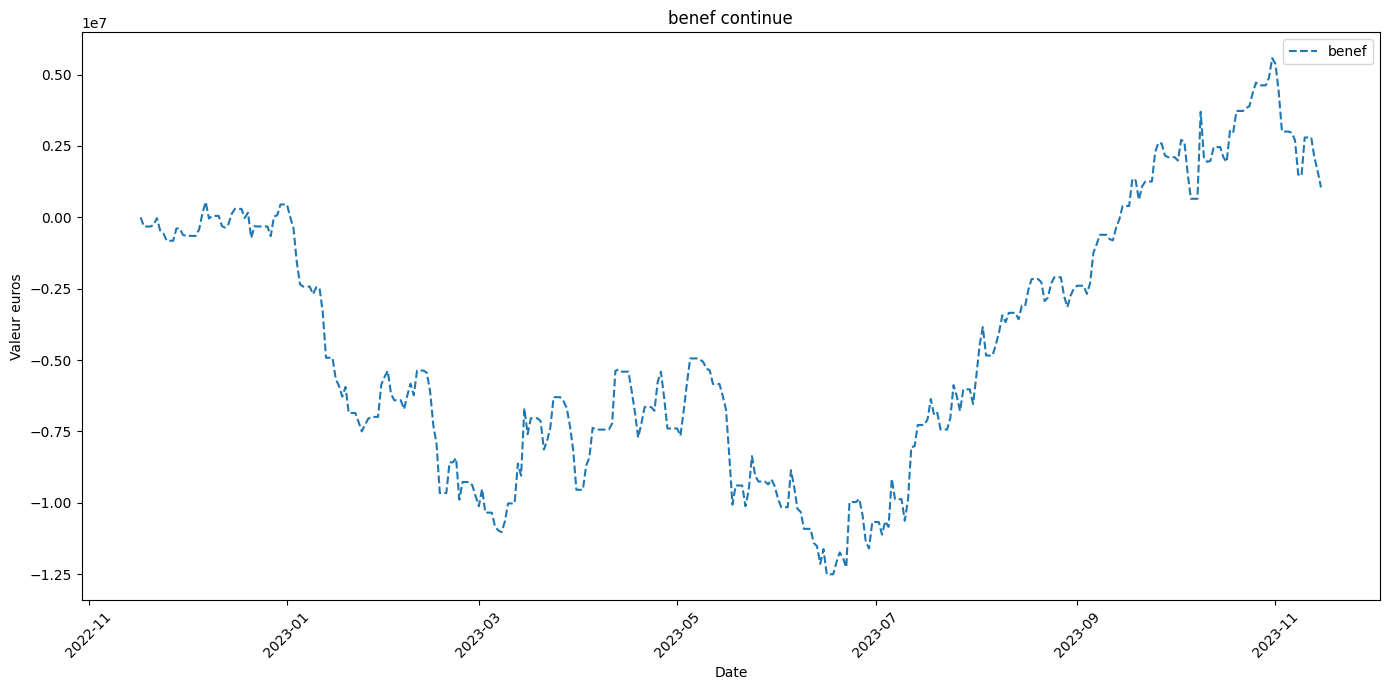

<Figure size 1400x700 with 0 Axes>

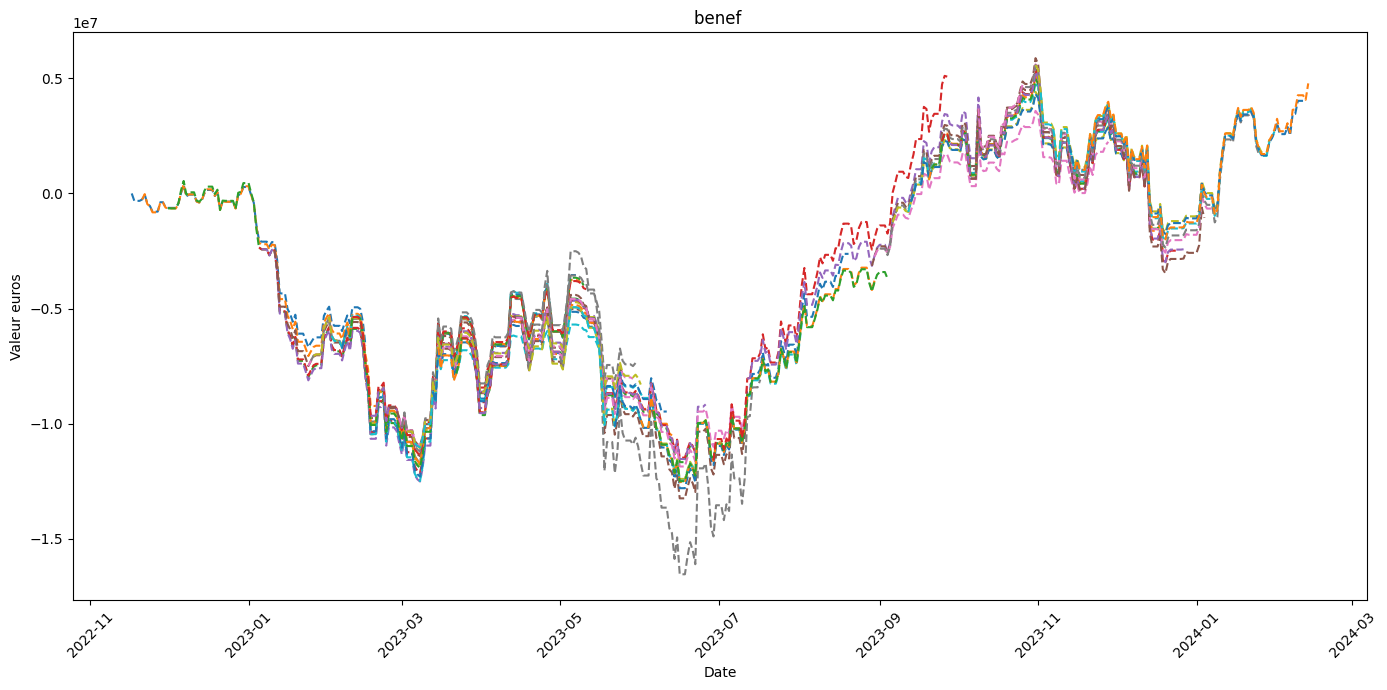

 % de bonne position sur une projection de 90 jours
32.69230769230769 %


In [20]:
emetteur =  'AIR FRANCE-KLM'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

### ELIS

[*********************100%%**********************]  1 of 1 completed


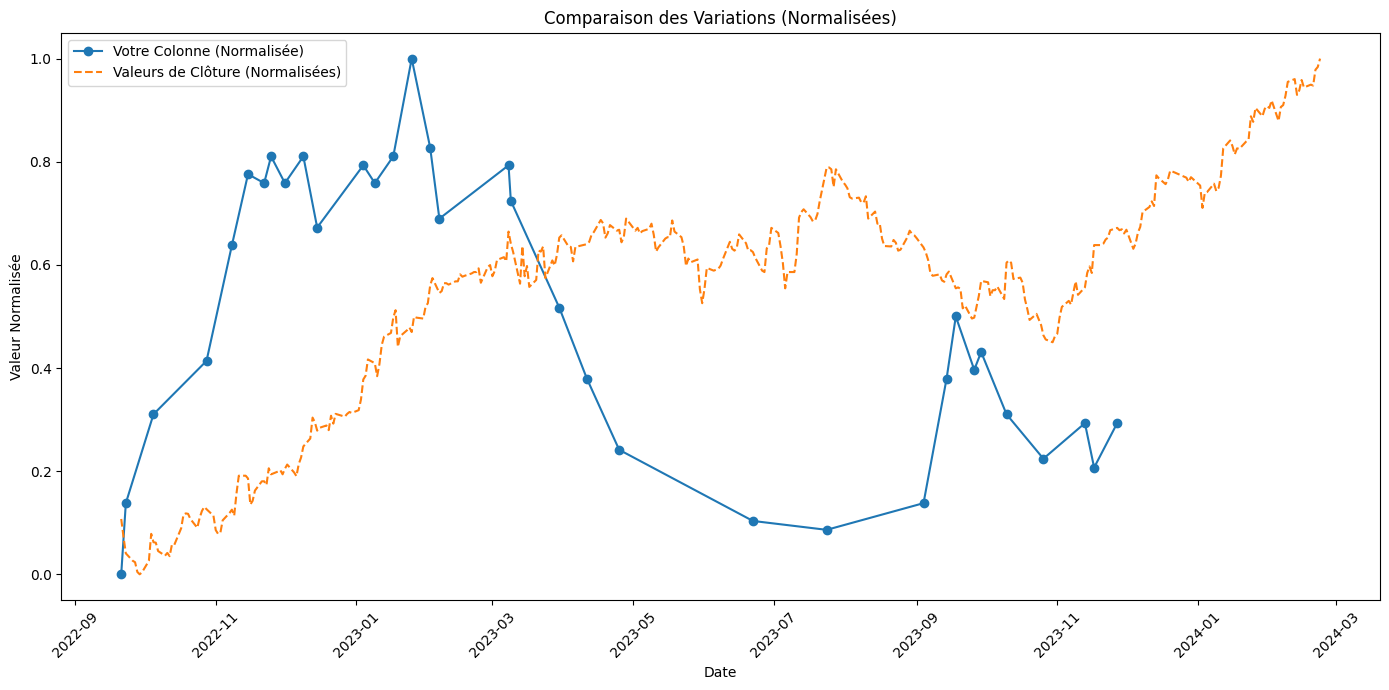

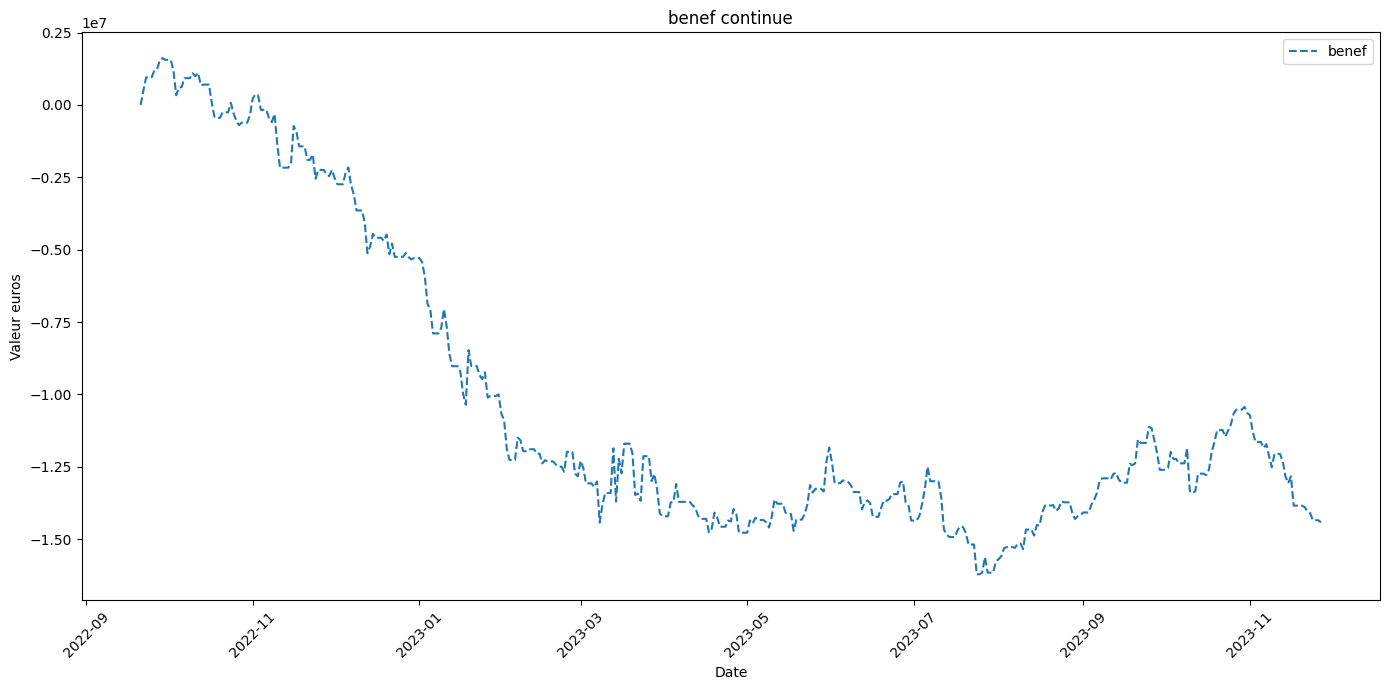

<Figure size 1400x700 with 0 Axes>

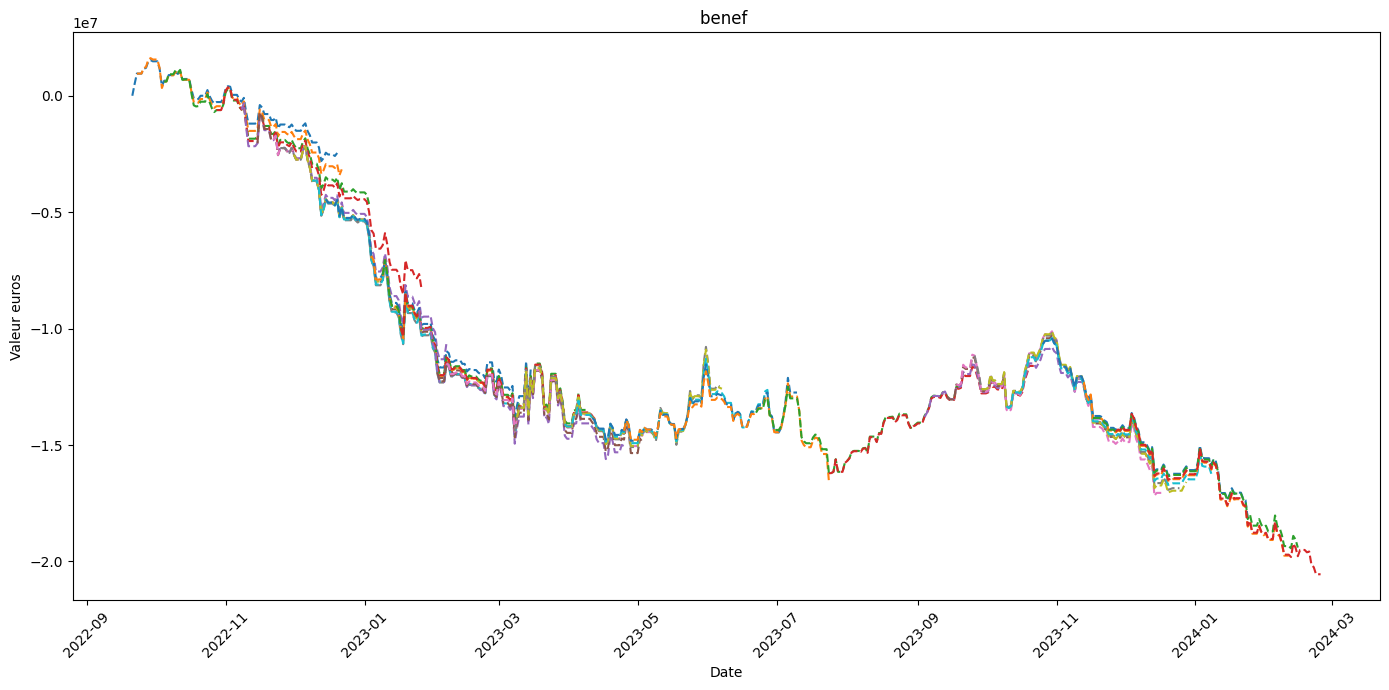

 % de bonne position sur une projection de 90 jours
0.0 %


In [21]:
emetteur =  'ELIS'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)

    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

# QUBE RESEARCH & TECHNOLOGIES LIMITED 

In [22]:
Holder = "QUBE RESEARCH & TECHNOLOGIES LIMITED"
visualiser_investissments(Holder, df_sorted)

### CGG

[*********************100%%**********************]  1 of 1 completed


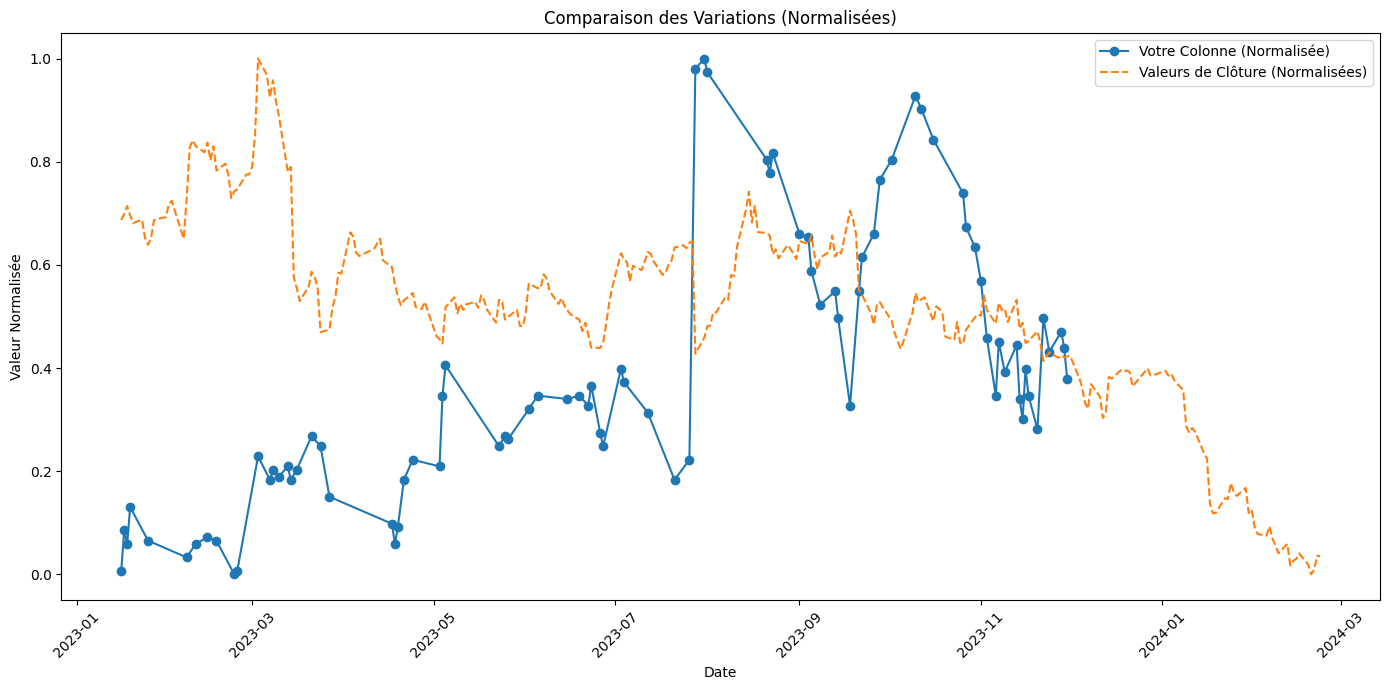

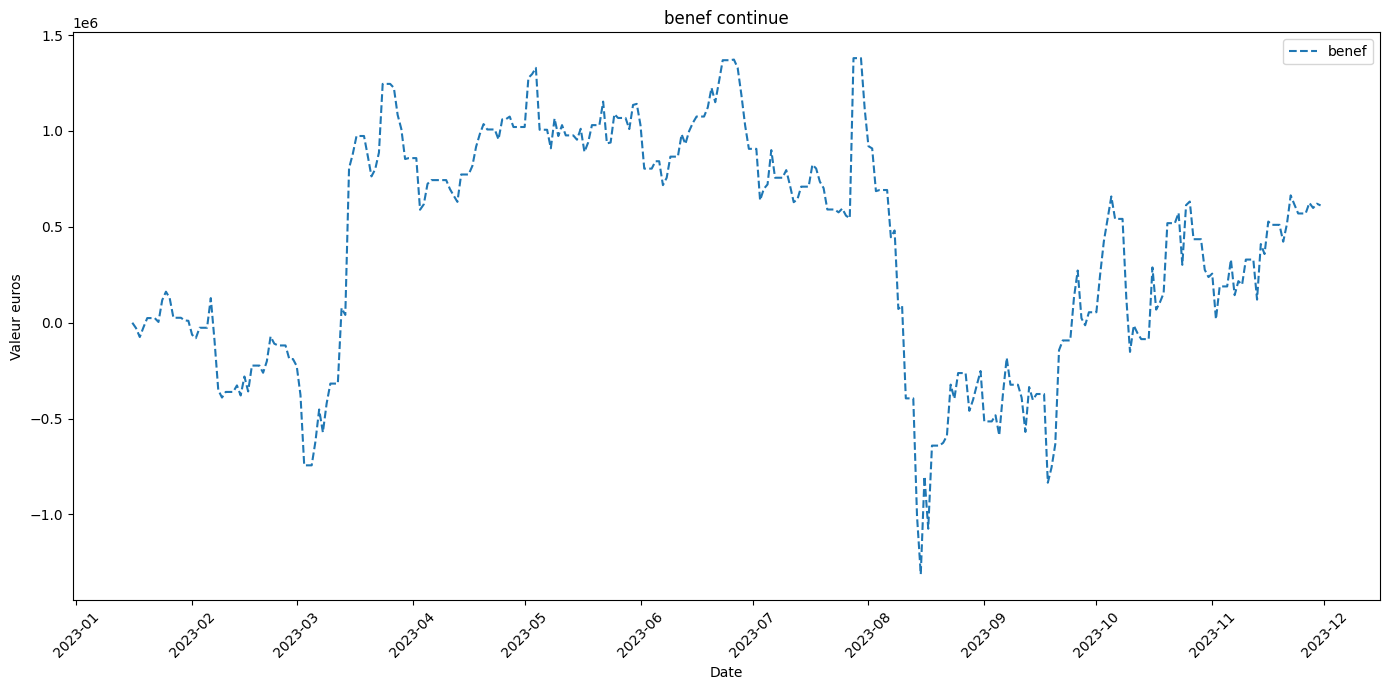

<Figure size 1400x700 with 0 Axes>

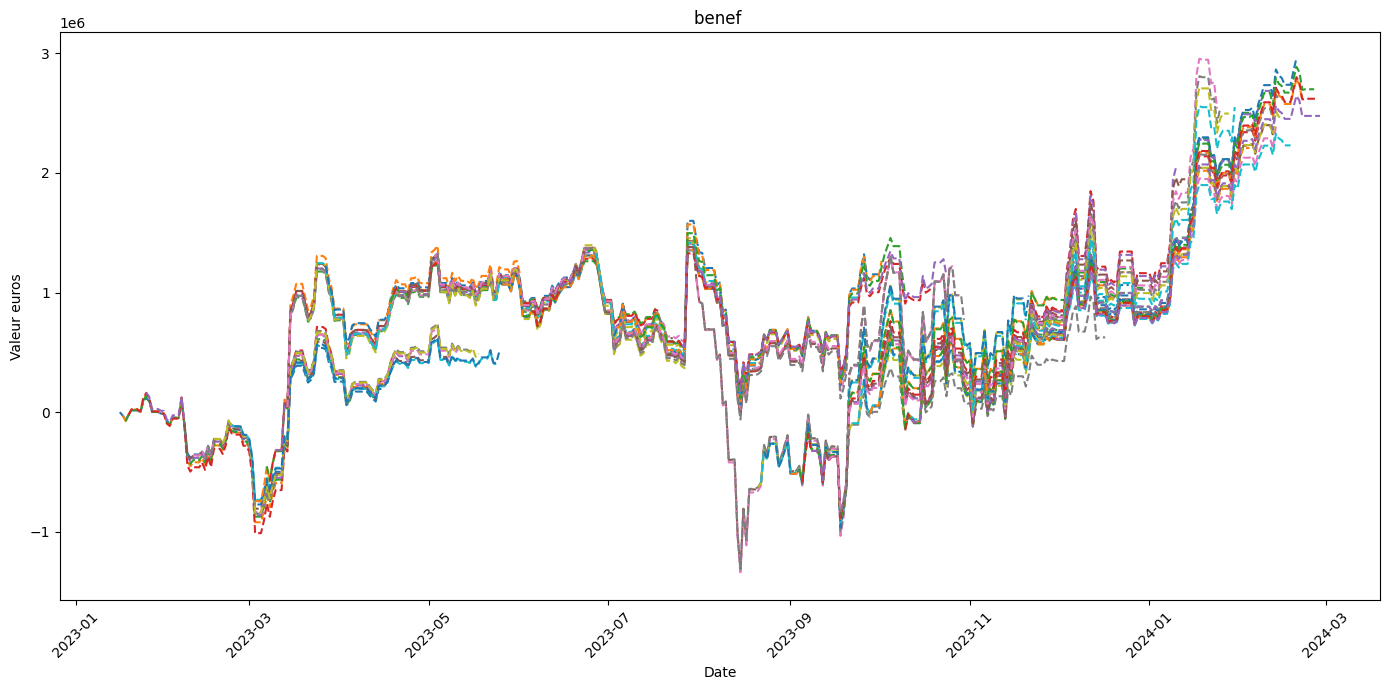

 % de bonne position sur une projection de 90 jours
95.29411764705883 %


In [23]:
emetteur =  'CGG'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

### ATOS

[*********************100%%**********************]  1 of 1 completed


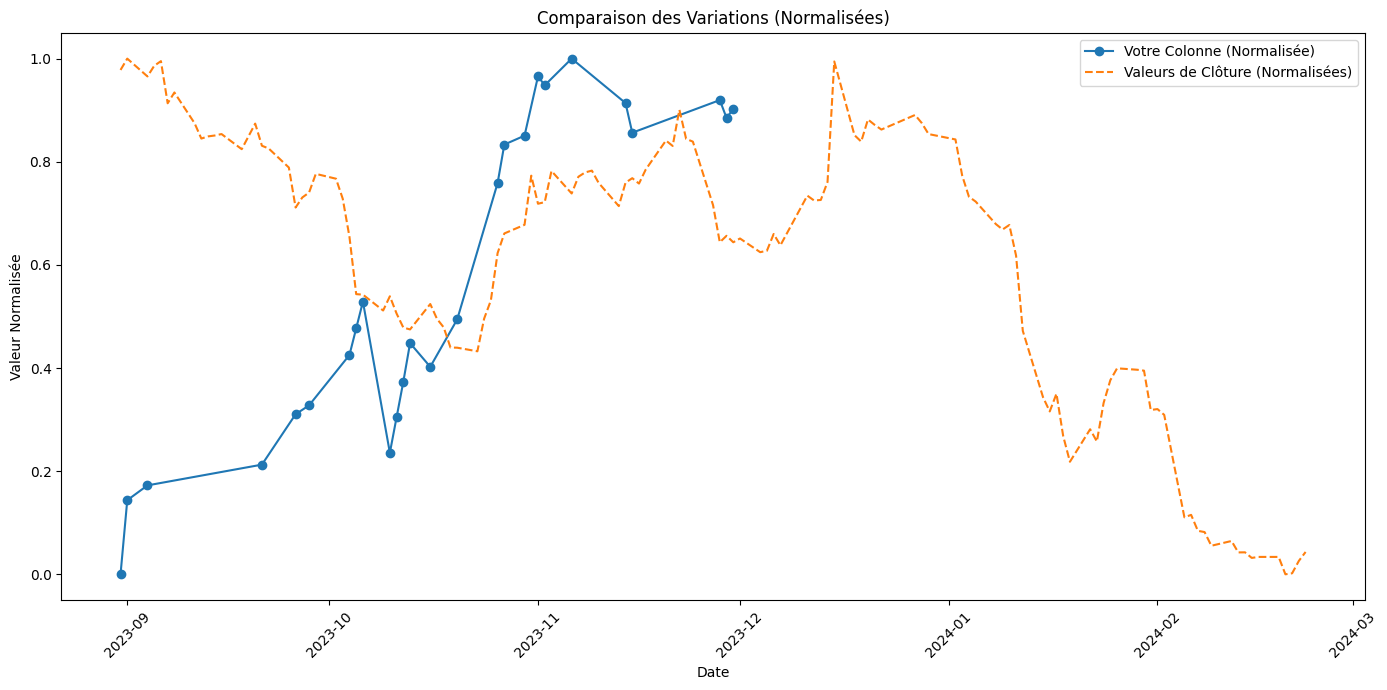

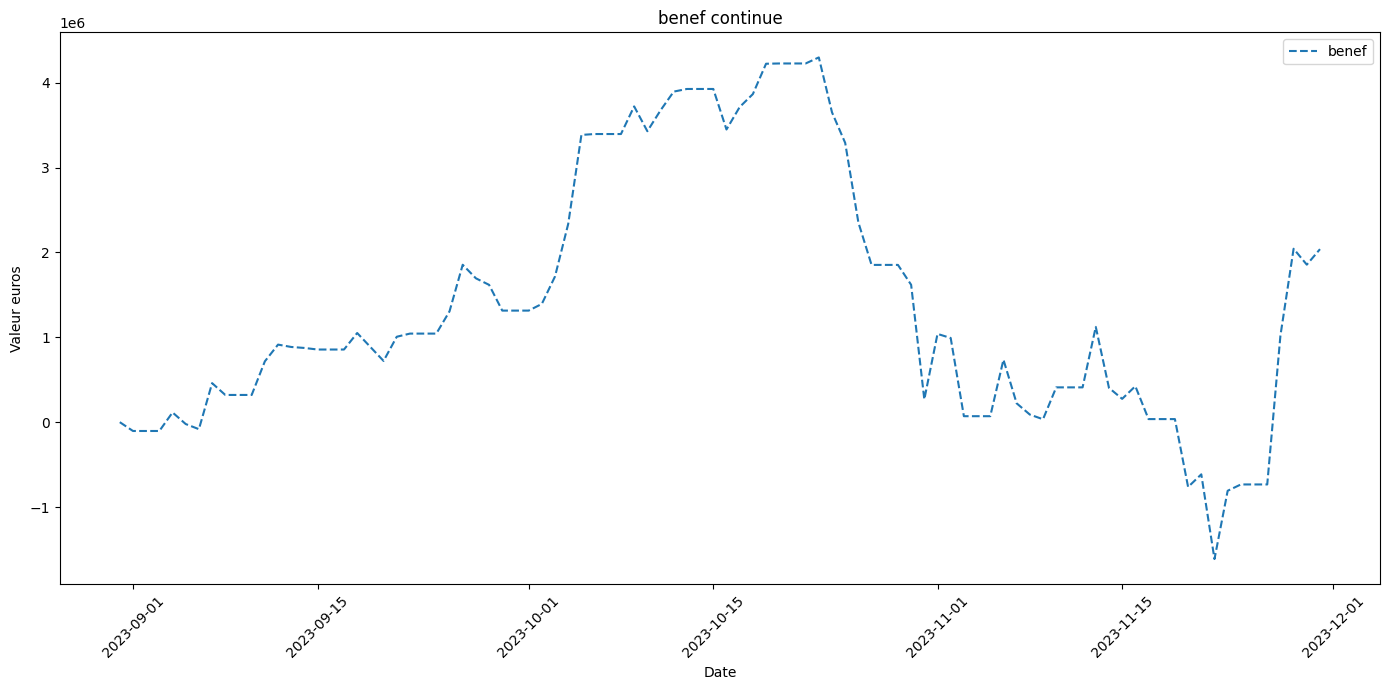

<Figure size 1400x700 with 0 Axes>

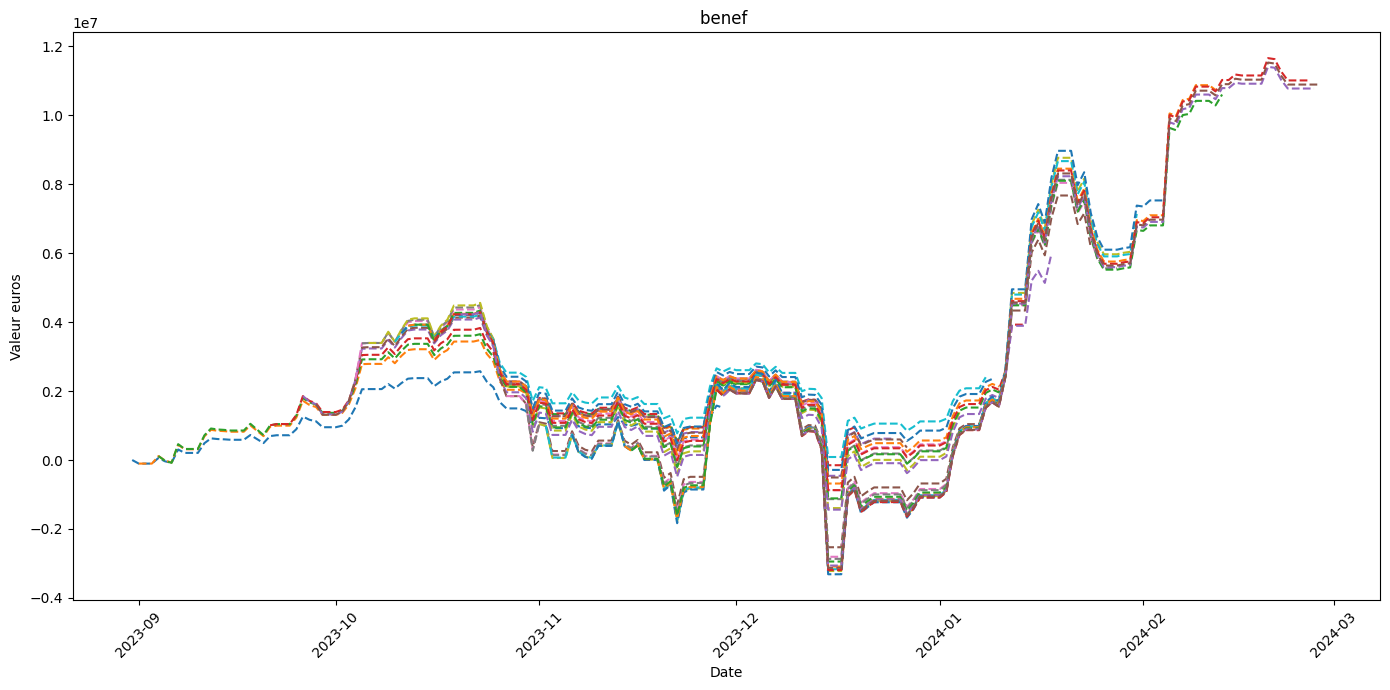

 % de bonne position sur une projection de 90 jours
100.0 %


In [24]:
emetteur =  'ATOS SE'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 


# MARSHALL WACE LLP

In [25]:
Holder = "MARSHALL WACE LLP"
visualiser_investissments(Holder, df_sorted)

### RENAULT 

[*********************100%%**********************]  1 of 1 completed


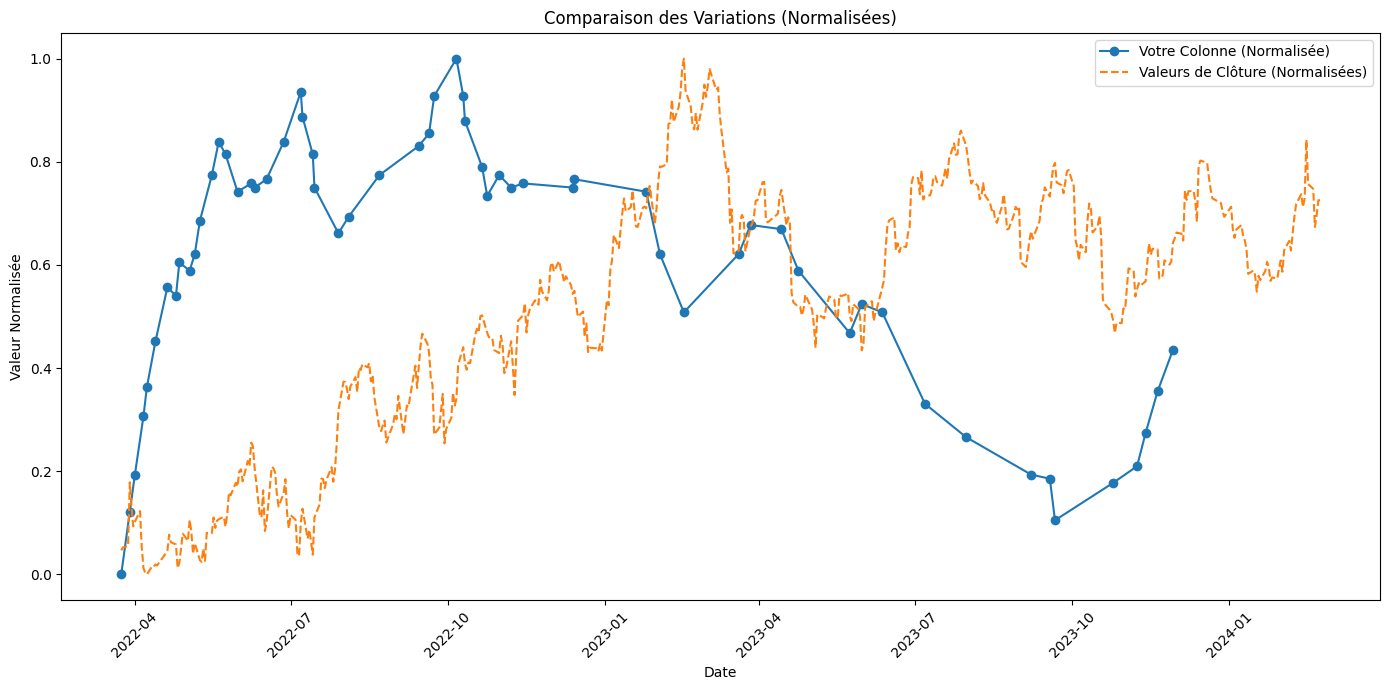

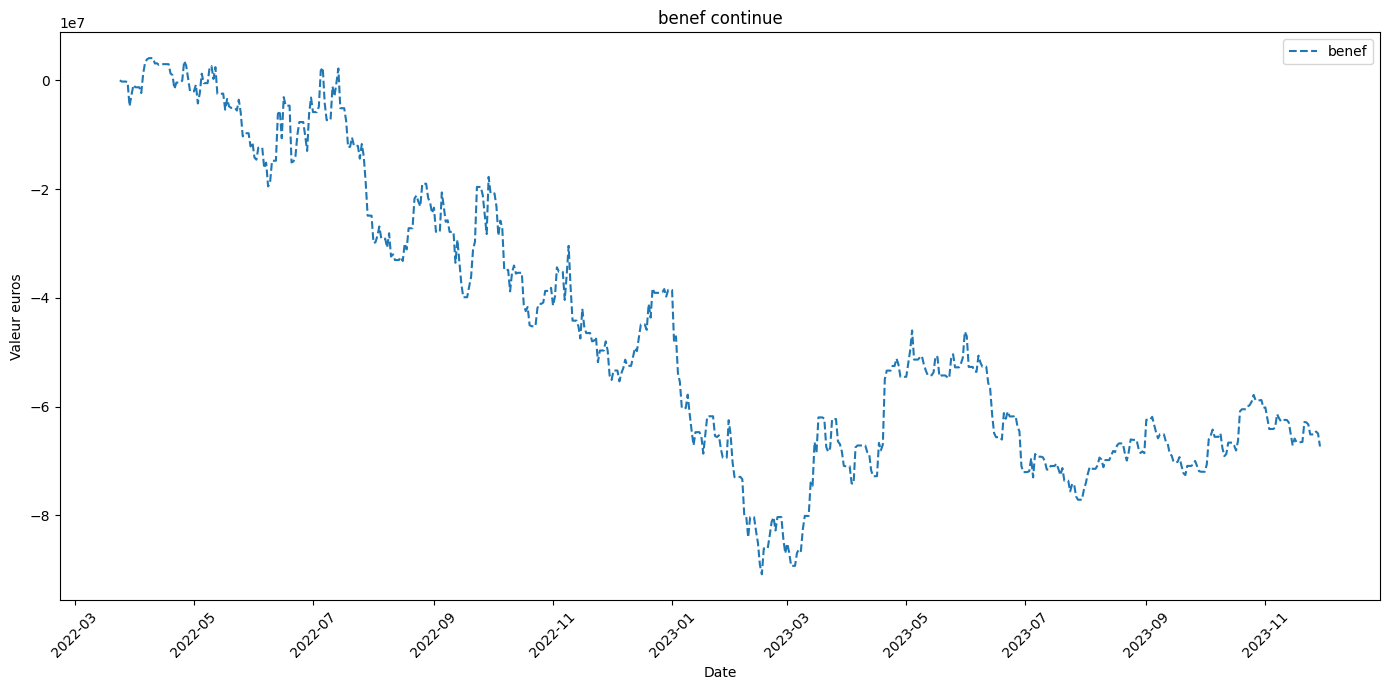

<Figure size 1400x700 with 0 Axes>

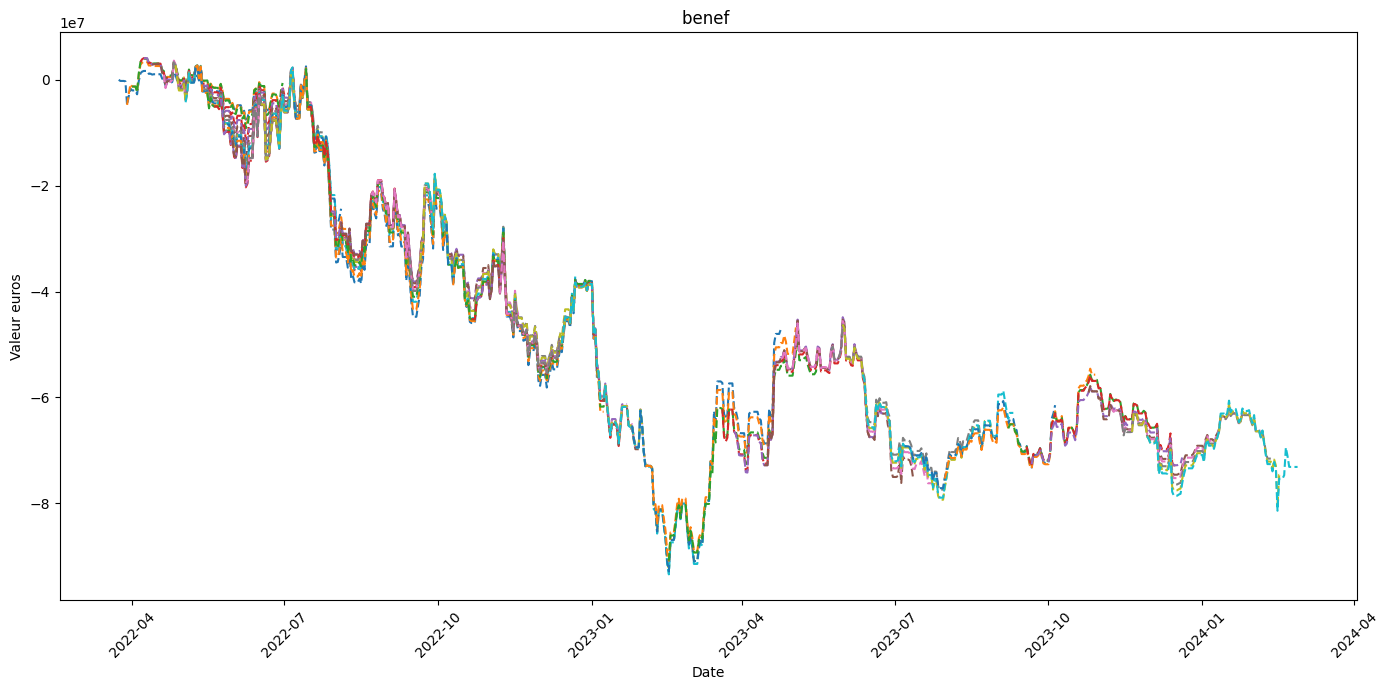

 % de bonne position sur une projection de 90 jours
0.0 %


In [26]:
emetteur =  'RENAULT'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows)

### CGG

[*********************100%%**********************]  1 of 1 completed


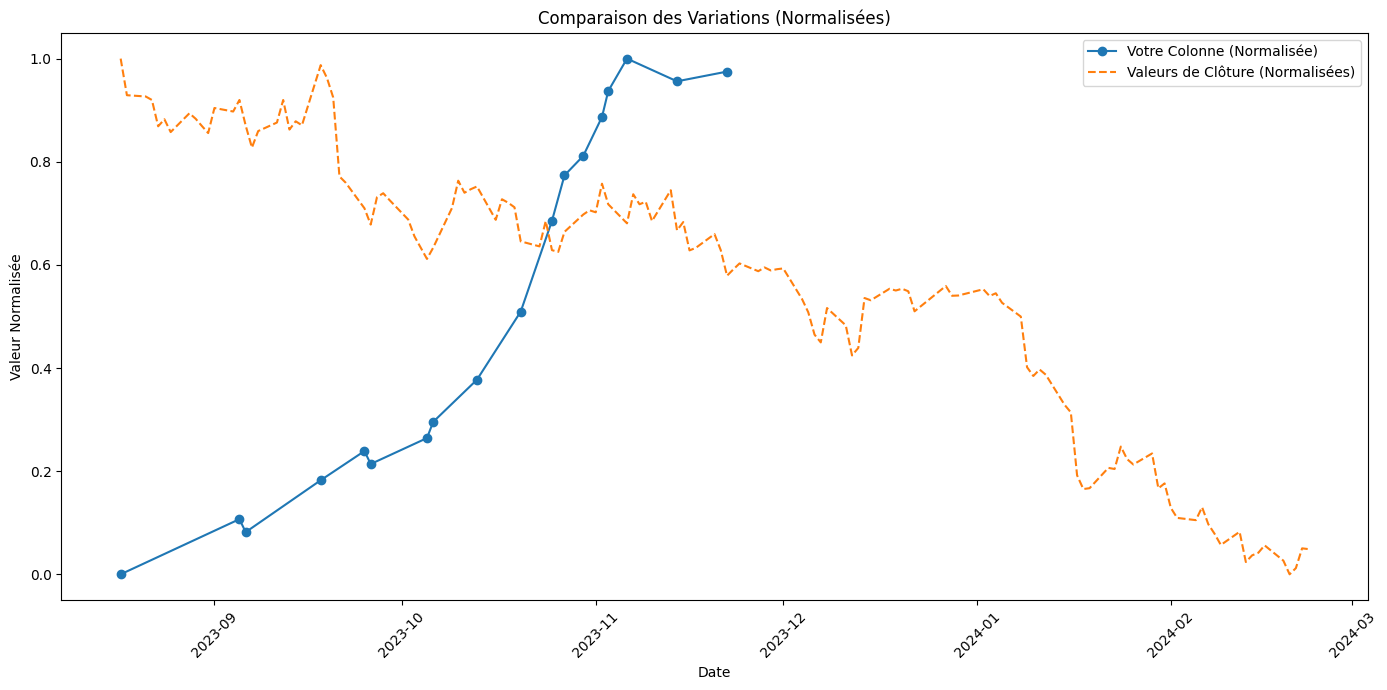

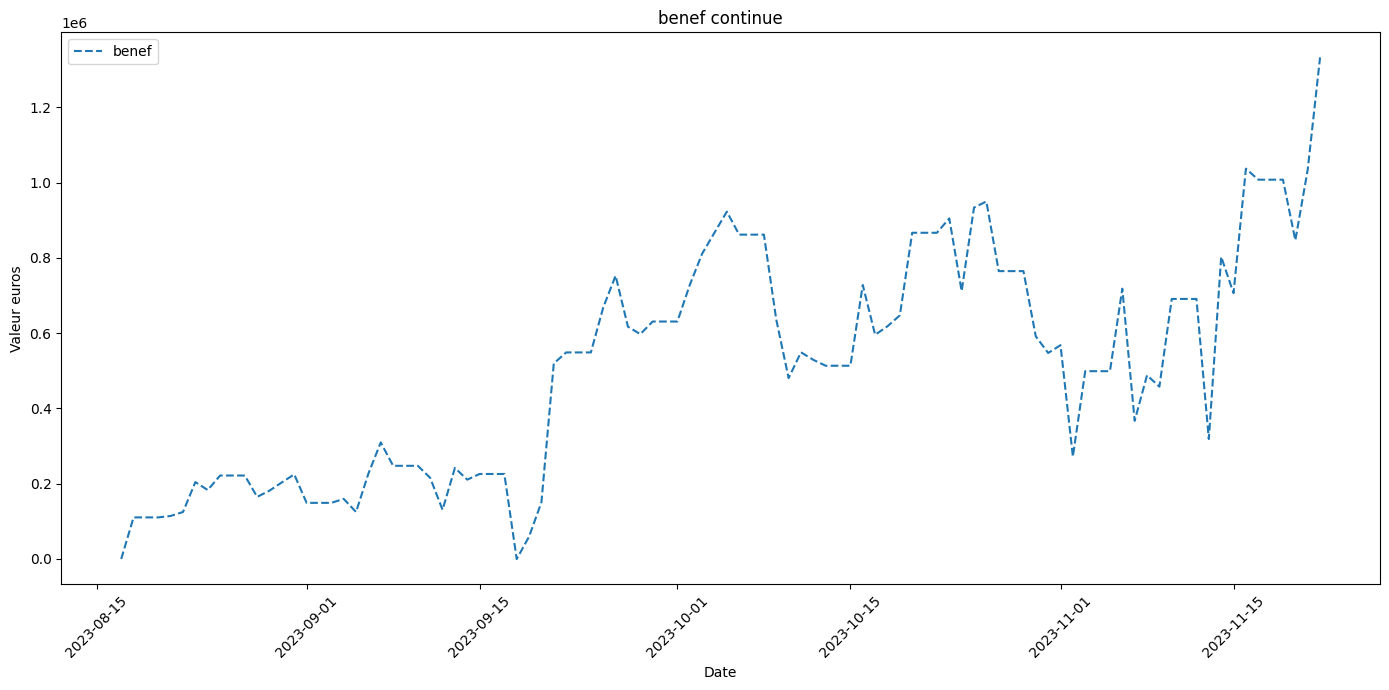

<Figure size 1400x700 with 0 Axes>

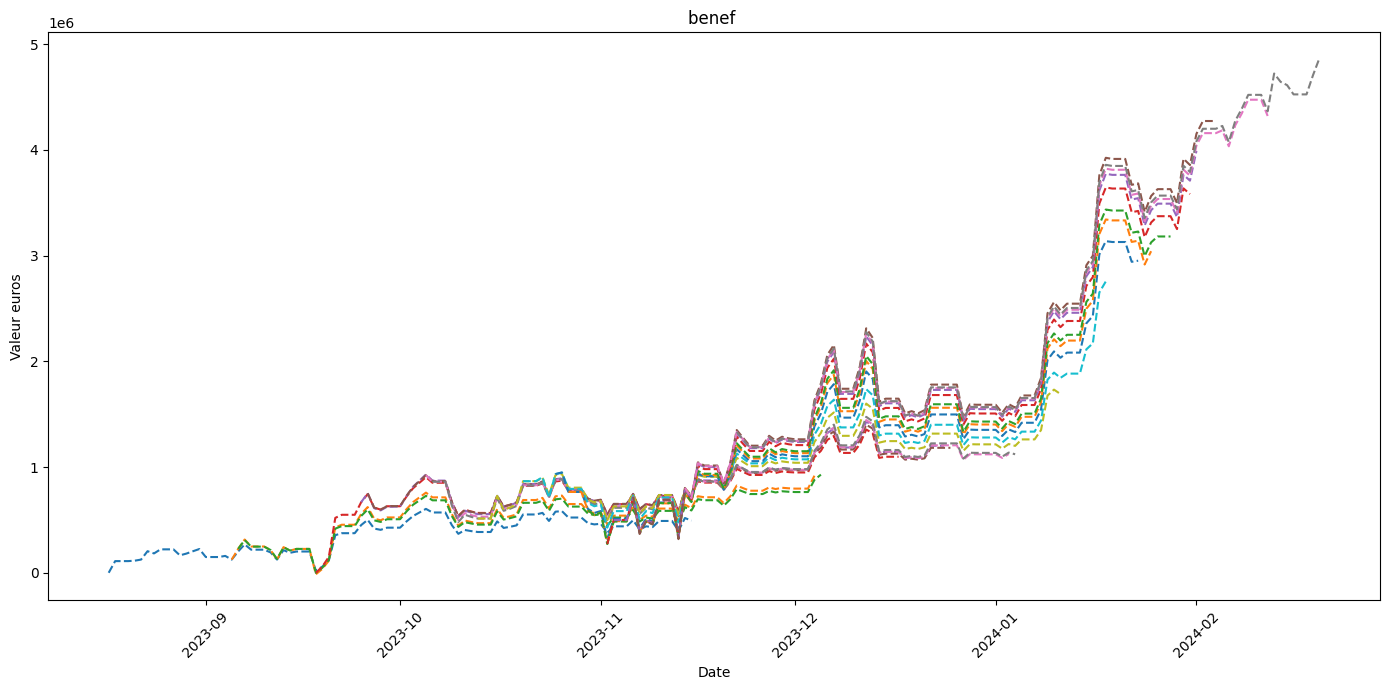

 % de bonne position sur une projection de 90 jours
100.0 %


In [27]:
emetteur =  'CGG'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

## AIR FRANCE-KLM

[*********************100%%**********************]  1 of 1 completed


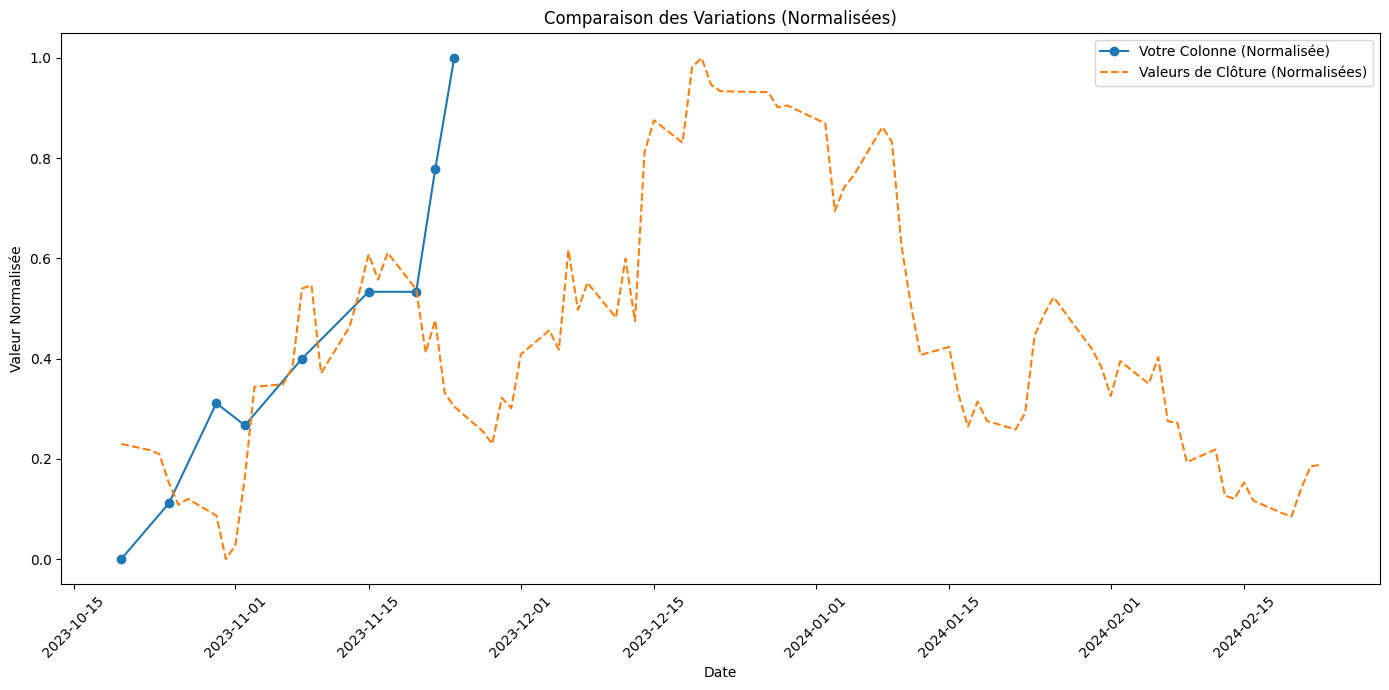

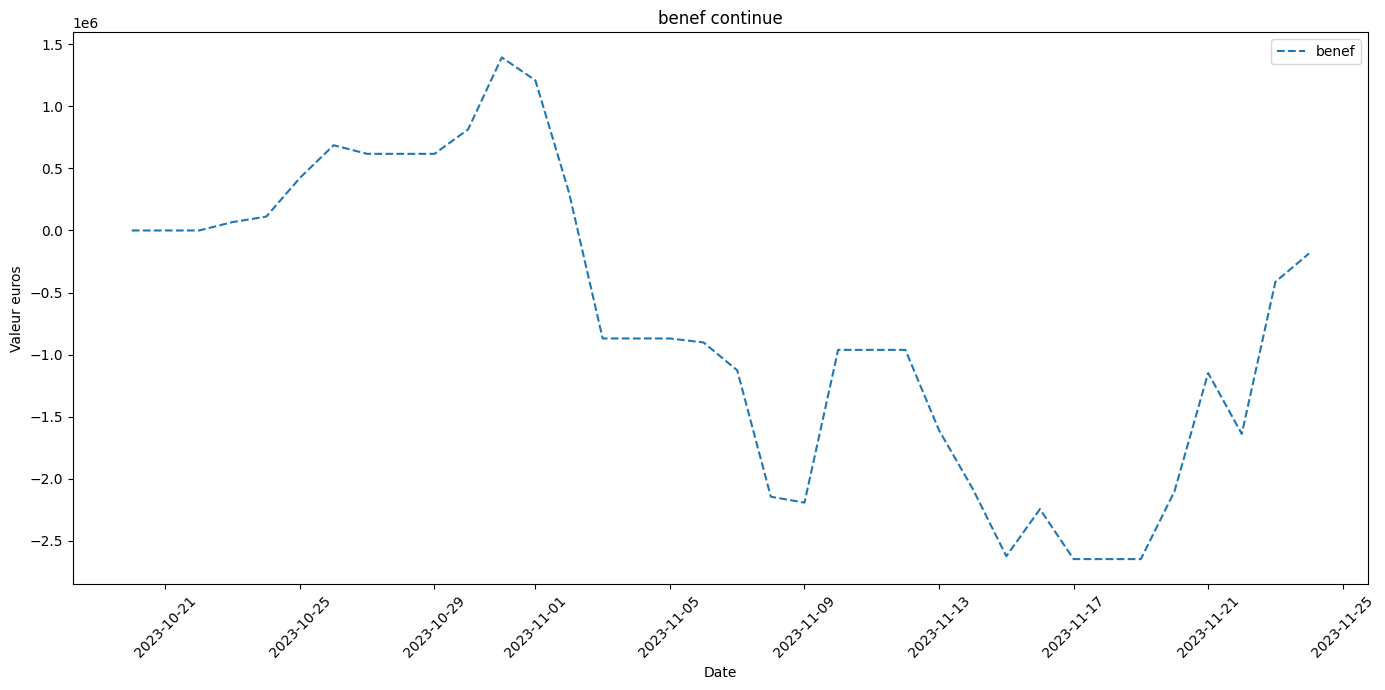

<Figure size 1400x700 with 0 Axes>

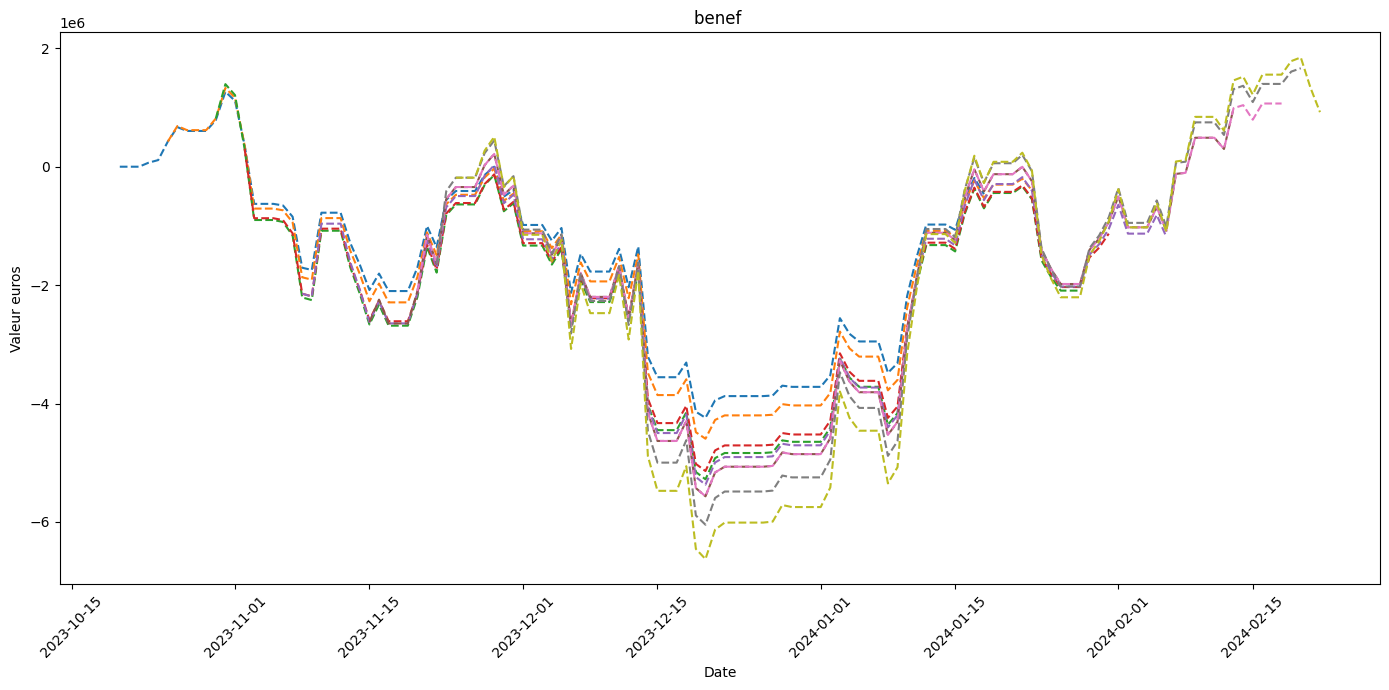

 % de bonne position sur une projection de 90 jours
0.0 %


In [28]:
emetteur =  'AIR FRANCE-KLM'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

# MILLENNIUM CAPITAL PARTNERS LLP

In [29]:
Holder  = "MILLENNIUM CAPITAL PARTNERS LLP"
visualiser_investissments(Holder, df_sorted, True)

### CASINO GUICHARD-PERRACHON

[*********************100%%**********************]  1 of 1 completed


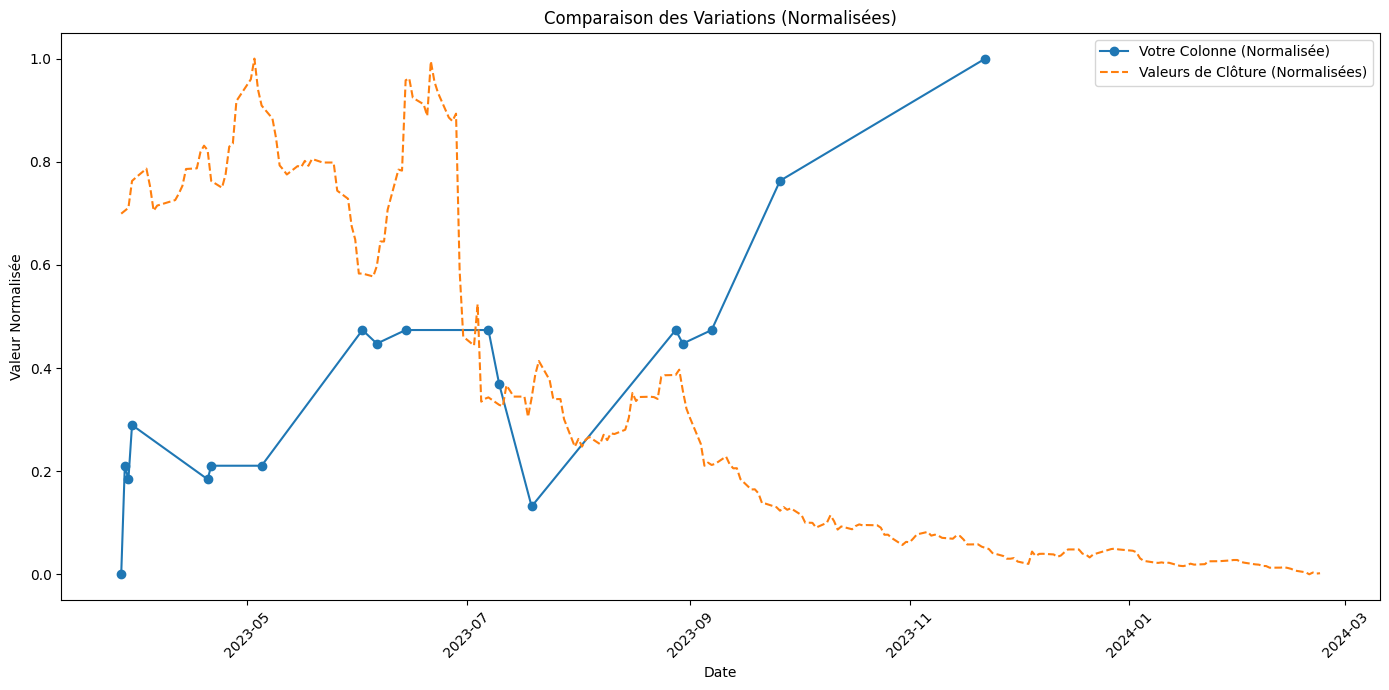

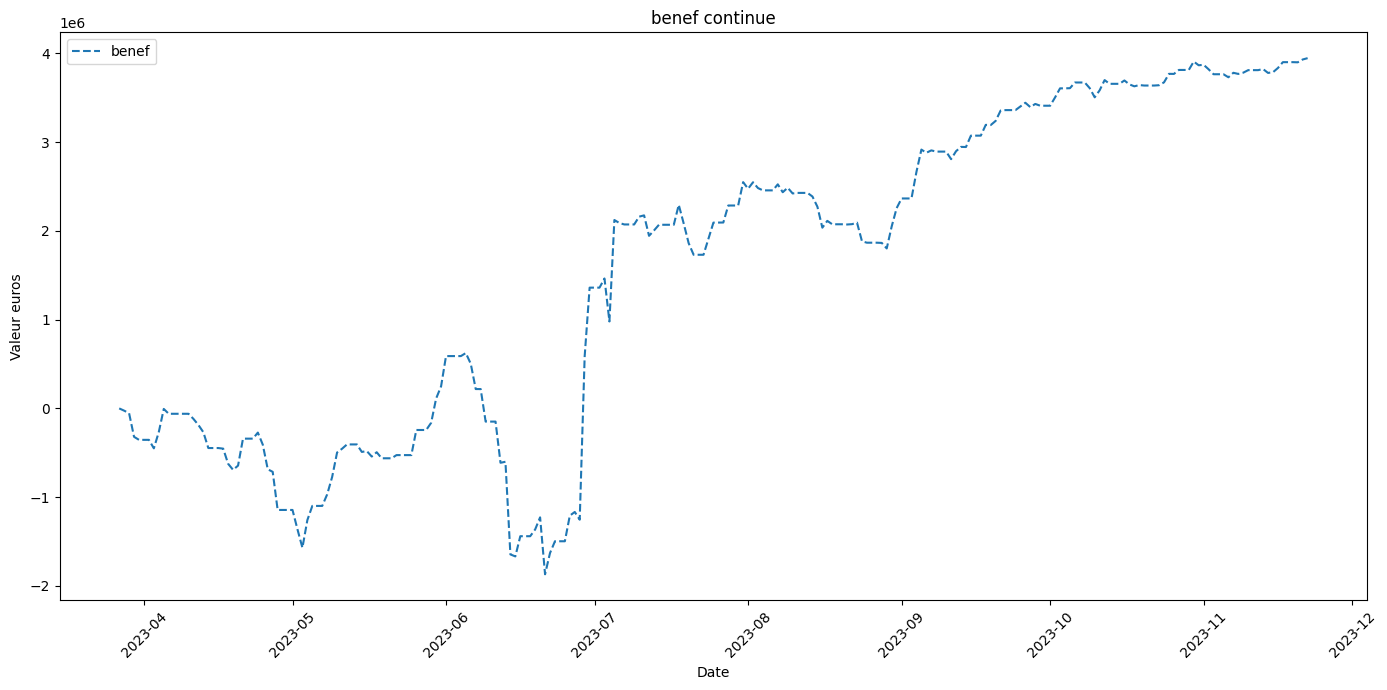

<Figure size 1400x700 with 0 Axes>

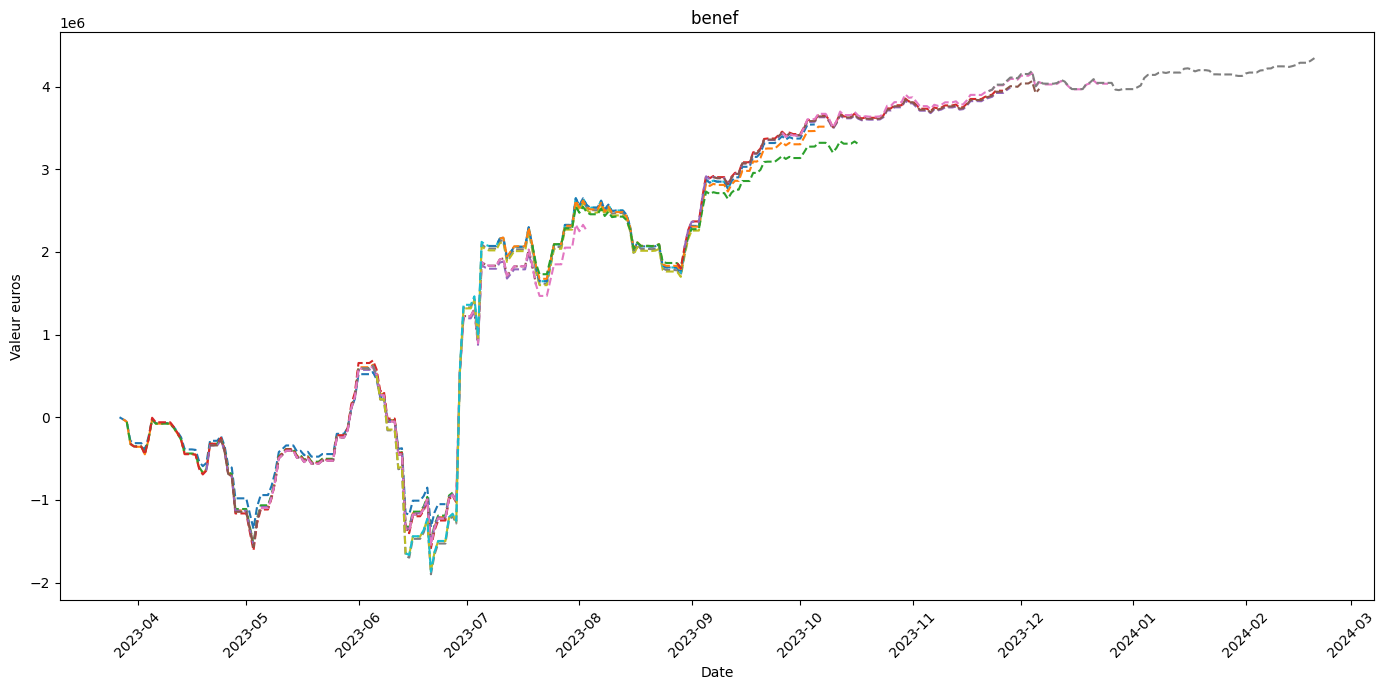

 % de bonne position sur une projection de 90 jours
66.66666666666667 %


In [30]:
emetteur =  'CASINO GUICHARD-PERRACHON'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

### ATOS

[*********************100%%**********************]  1 of 1 completed


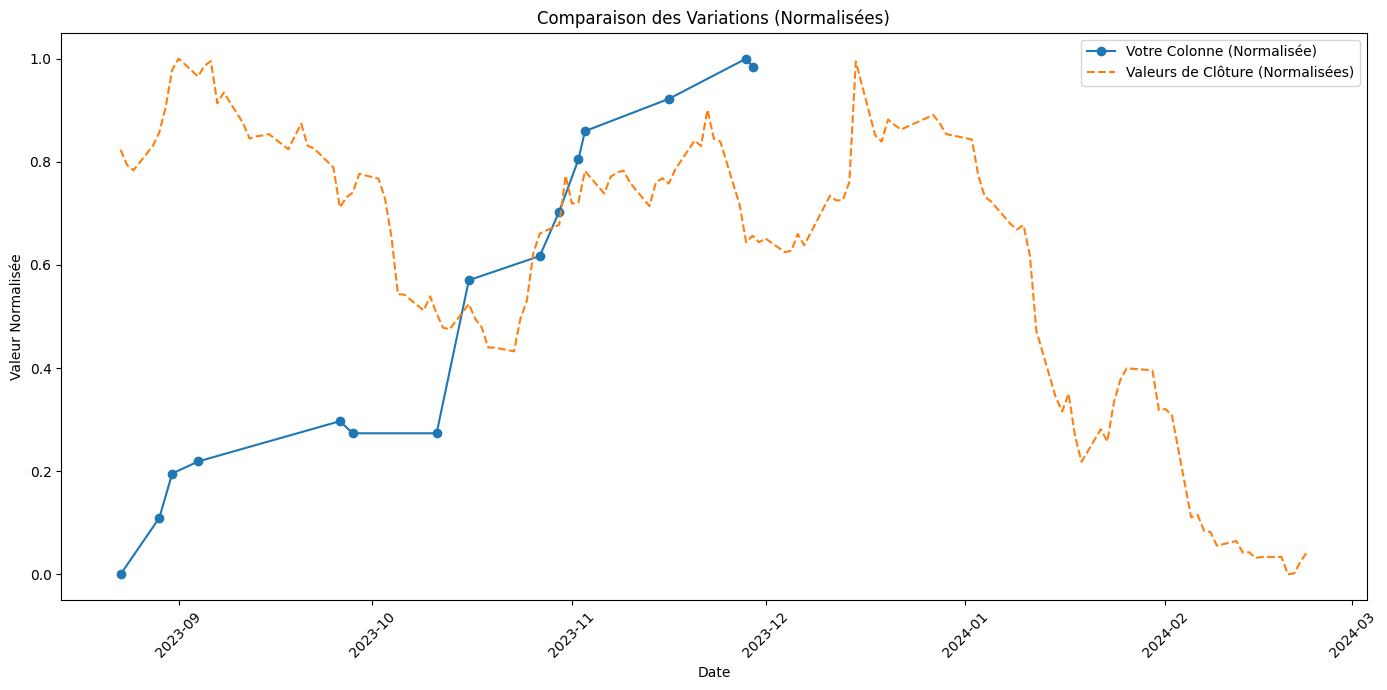

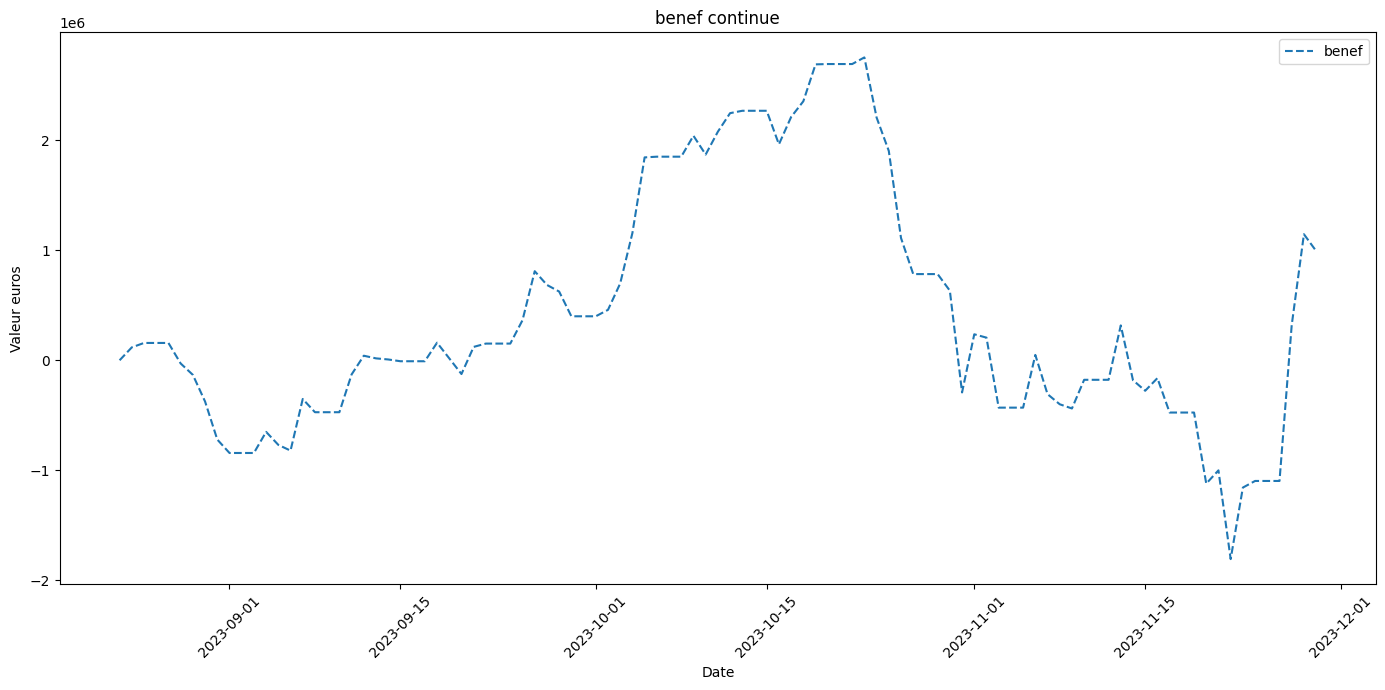

<Figure size 1400x700 with 0 Axes>

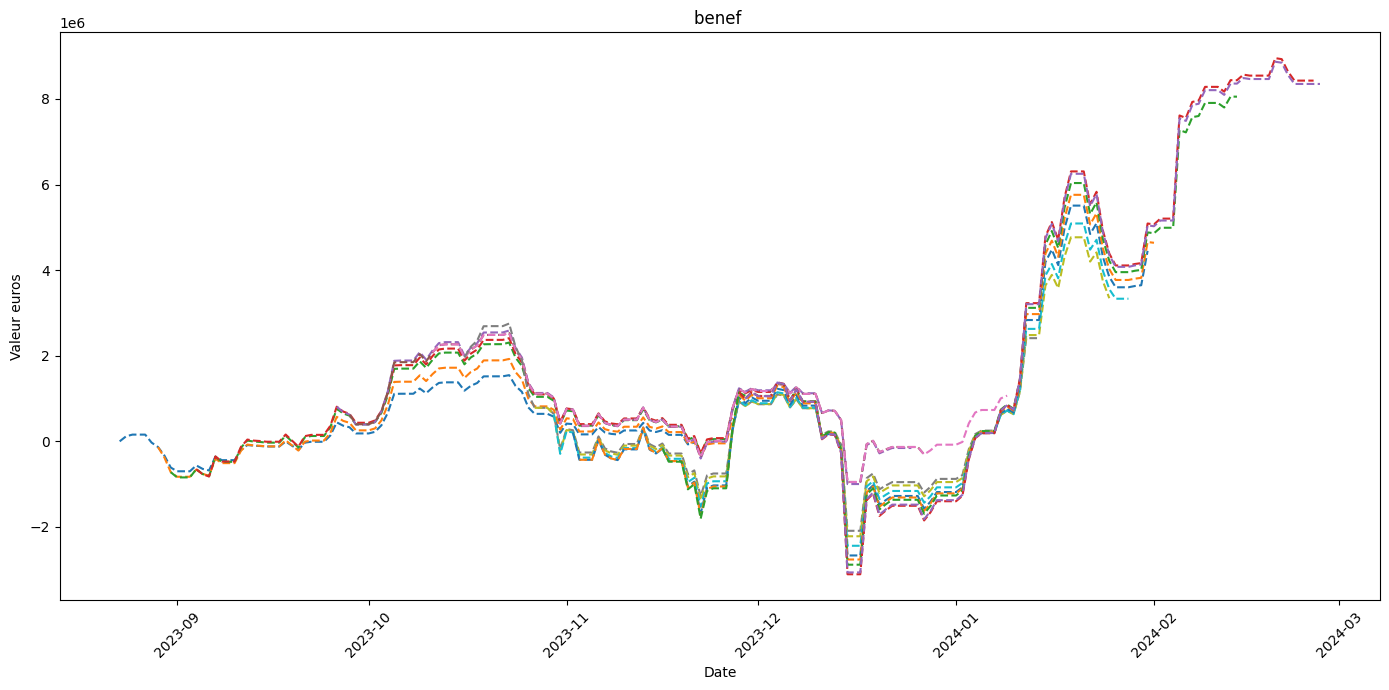

 % de bonne position sur une projection de 90 jours
100.0 %


In [31]:
emetteur =  'ATOS SE'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    benef_continue(data,cgg_rows,total_titre)
    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 

### REXEL

[*********************100%%**********************]  1 of 1 completed


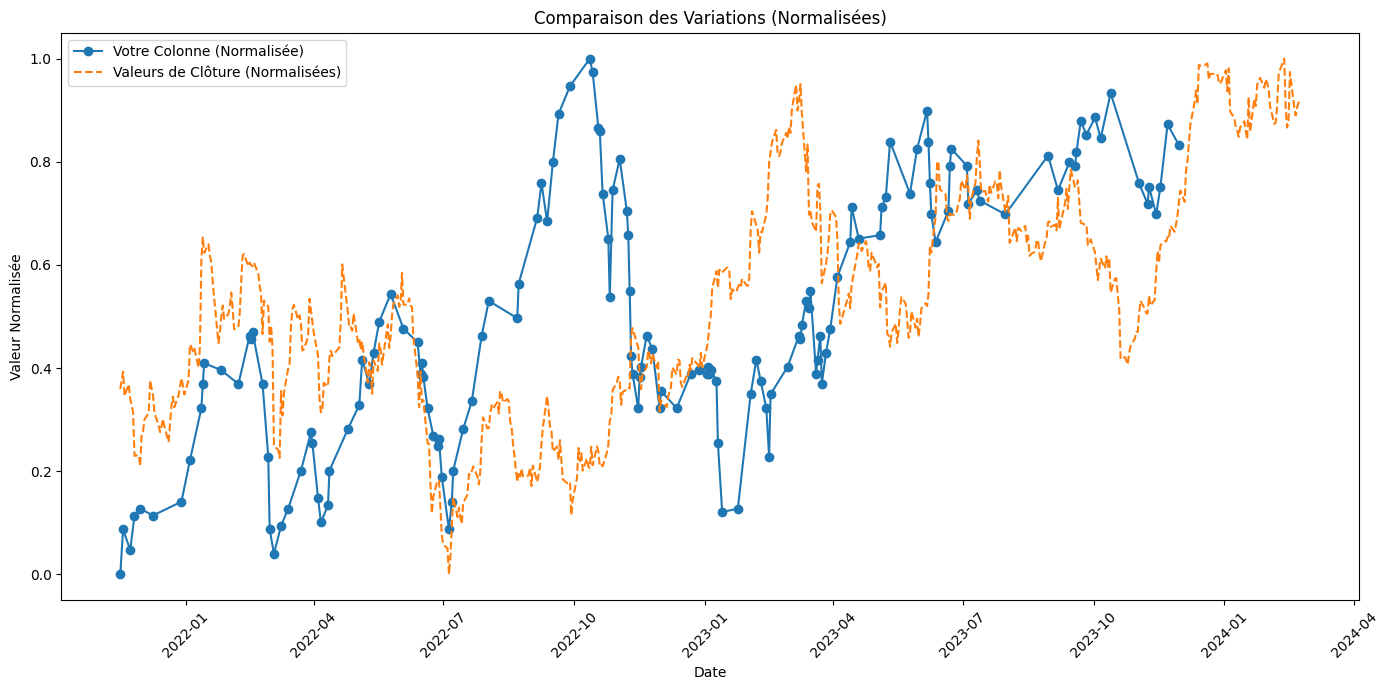

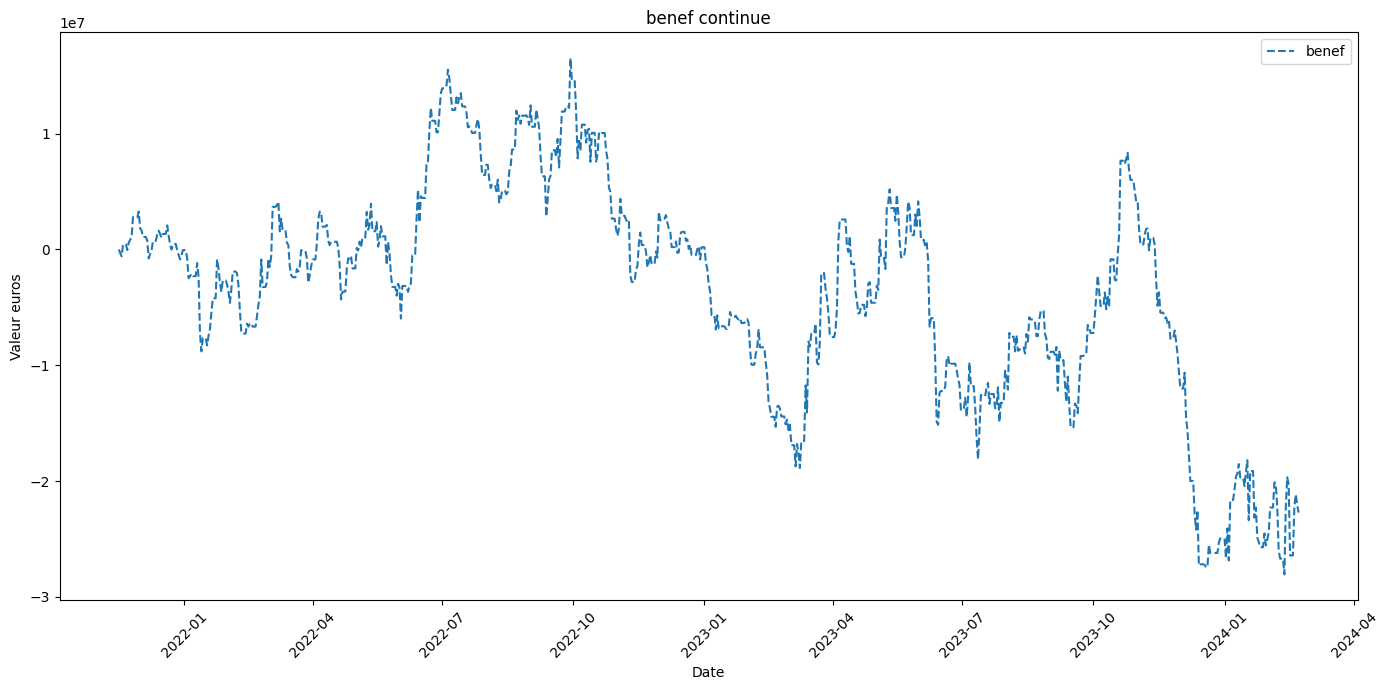

<Figure size 1400x700 with 0 Axes>

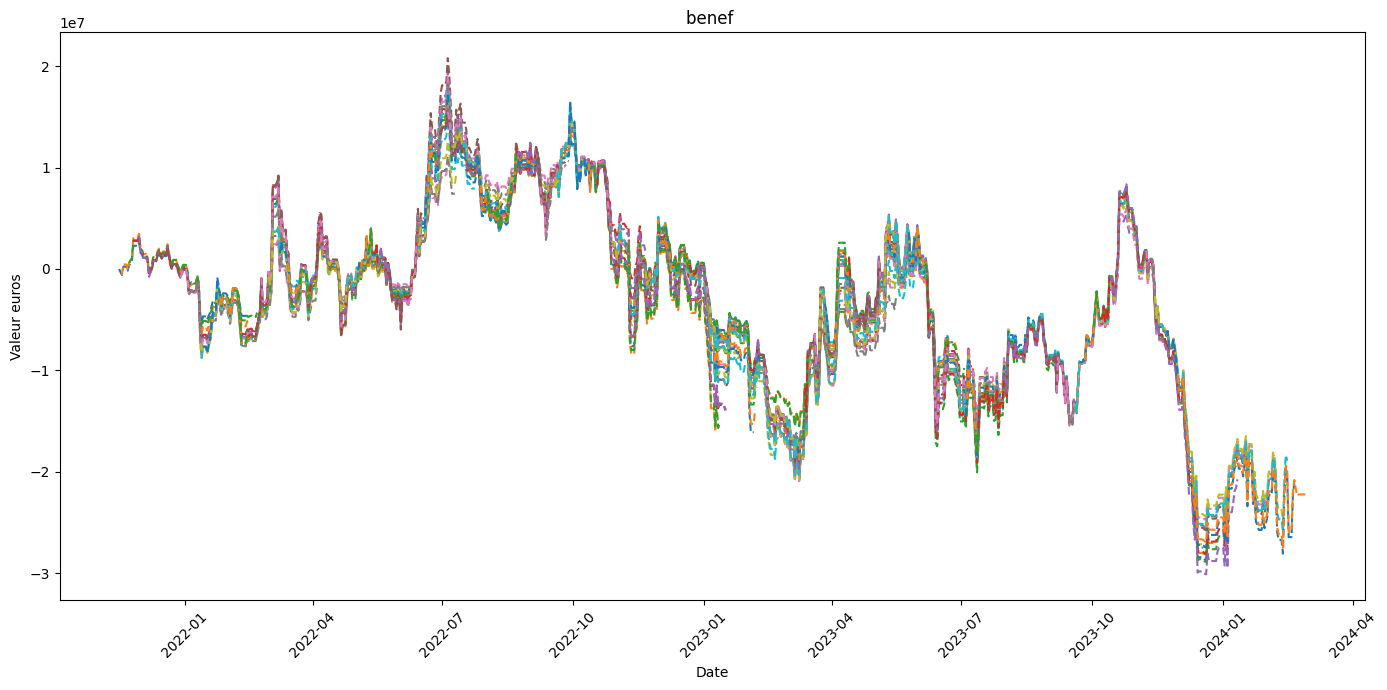

 % de bonne position sur une projection de 90 jours
25.657894736842106 %


In [32]:
emetteur =  'REXEL'
cgg_rows , start_date = visualiser_investissment(Holder,emetteur,df_sorted,False)

ticker = ticker_dic.get(emetteur, False)
if ticker :
    data = visuel_action_invest_min_max(start_date,cgg_rows,ticker)
    total_titre = get_nombre_total_titre(ticker.split('.')[0])
    data_benef = benef_continue(data,cgg_rows,total_titre,True)

    add_how_many_days = 90
    pertinence_position_sur(add_how_many_days,data,total_titre,cgg_rows) 
    #benef(data,cgg_rows,total_titre)

In [33]:
data_benef.mean()

-3559248.519795275

In [34]:
data_benef.mean() + data_benef.std()

5967285.609085064

In [35]:
data_benef.mean() - data_benef.std()

-13085782.648675613

In [36]:
data_benef.min()

-28064565.539137125

In [37]:
data_benef.max()

16530289.523976356

In [38]:
#data_benef.

# Recherche de période 

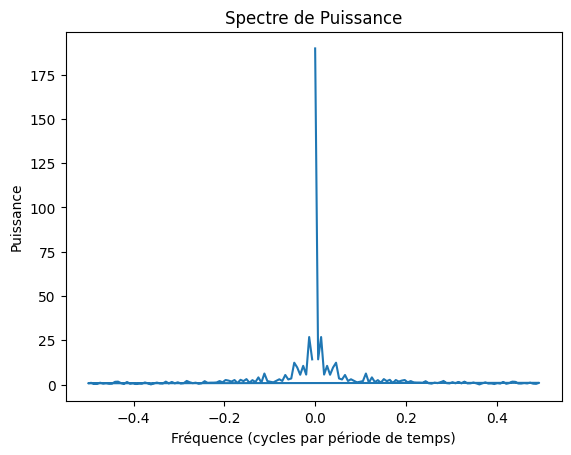

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Supposons que 'values' est un array numpy de vos valeurs standardisées
values =np.array(cgg_rows[cgg_rows.columns[0]]) 

# Analyse de Fourier pour détecter les fréquences dominantes
fft_values = np.fft.fft(values)
frequencies = np.fft.fftfreq(len(values))

# Tracer le spectre de puissance
power = np.abs(fft_values)
plt.plot(frequencies, power)
plt.title('Spectre de Puissance')
plt.xlabel('Fréquence (cycles par période de temps)')
plt.ylabel('Puissance')

# Identifier les pics dans le spectre de puissance pour détecter les cycles dominants
# Vous devrez définir un seuil pour déterminer ce qui est considéré comme un "pic" significatif

plt.show()


In [40]:
import numpy as np

# Effectuer l'analyse de Fourier
fft_values = np.fft.fft(values)
frequencies = np.fft.fftfreq(len(values), d=1)  # d est la période d'échantillonnage, mettre la valeur appropriée
power = np.abs(fft_values)

# Identifier les pics dans le spectre de puissance
threshold = 0.02 * np.max(power)  # Seuil arbitraire, à ajuster selon vos données
peaks = power > threshold

# Convertir les fréquences des pics en périodes temporelles (en jours)
peak_frequencies = frequencies[peaks]
peak_periods = 1 / peak_frequencies

# Afficher les pics et leurs périodes correspondantes
for freq, period in zip(peak_frequencies, peak_periods):
    print(f"Pic à la fréquence {freq} correspond à une période de {period} jours")

# Supposons que vous avez un DataFrame 'df' avec une colonne 'Date' et une colonne 'Values'
# Vous pouvez maintenant segmenter votre DataFrame en sous-ensembles correspondant à chaque période dominante
# Pour simplifier, prenons une période dominante pour l'exemple
dominant_period = np.min(peak_periods[peak_periods > 0])  # Période la plus courte non nulle
num_periods = int(len(values) / dominant_period)

# Créer des sous-ensembles de valeurs pour chaque cycle
subsets = [values[i * int(dominant_period):(i + 1) * int(dominant_period)] for i in range(num_periods)]

# Chaque sous-ensemble dans 'subsets' correspond à un cycle de la période dominante


Pic à la fréquence 0.0 correspond à une période de inf jours
Pic à la fréquence 0.006578947368421052 correspond à une période de 152.0 jours
Pic à la fréquence 0.013157894736842105 correspond à une période de 76.0 jours
Pic à la fréquence 0.019736842105263157 correspond à une période de 50.66666666666667 jours
Pic à la fréquence 0.02631578947368421 correspond à une période de 38.0 jours
Pic à la fréquence 0.03289473684210526 correspond à une période de 30.400000000000002 jours
Pic à la fréquence 0.039473684210526314 correspond à une période de 25.333333333333336 jours
Pic à la fréquence 0.046052631578947366 correspond à une période de 21.714285714285715 jours
Pic à la fréquence 0.06578947368421052 correspond à une période de 15.200000000000001 jours
Pic à la fréquence 0.11184210526315788 correspond à une période de 8.941176470588236 jours
Pic à la fréquence 0.125 correspond à une période de 8.0 jours
Pic à la fréquence -0.125 correspond à une période de -8.0 jours
Pic à la fréquence -0

C:\Users\emac\AppData\Local\Temp\ipykernel_40436\3312183671.py:14: RuntimeWarning:

divide by zero encountered in divide



In [41]:
subsets

[array([0.51, 0.64, 0.58, 0.68, 0.7 , 0.68, 0.72, 0.84]),
 array([0.99, 1.06, 1.12, 1.1 , 1.06, 1.2 , 1.19, 1.21]),
 array([1.06, 0.85, 0.64, 0.57, 0.65, 0.7 , 0.81, 0.92]),
 array([0.89, 0.73, 0.66, 0.71, 0.81, 0.93, 1.  , 1.13]),
 array([1.06, 1.15, 1.24, 1.32, 1.22, 1.18, 1.09, 1.12]),
 array([1.08, 0.99, 0.91, 0.88, 0.9 , 0.79, 0.64, 0.72]),
 array([0.81, 0.93, 1.01, 1.2 , 1.3 , 1.25, 1.35, 1.54]),
 array([1.64, 1.53, 1.7 , 1.84, 1.92, 2.  , 1.96, 1.8 ]),
 array([1.79, 1.61, 1.48, 1.31, 1.62, 1.71, 1.56, 1.49]),
 array([1.33, 1.14, 1.09, 0.99, 1.08, 1.11, 1.2 , 1.16]),
 array([0.99, 1.04, 0.99, 1.09, 1.1 , 1.09, 1.11, 1.09]),
 array([1.1 , 1.07, 0.89, 0.69, 0.7 , 1.03, 1.13, 1.07]),
 array([0.99, 0.85, 1.03, 1.11, 1.2 , 1.19, 1.23, 1.3 ]),
 array([1.28, 1.33, 1.09, 1.13, 1.2 , 1.06, 1.15, 1.22]),
 array([1.37, 1.47, 1.57, 1.48, 1.49, 1.57, 1.6 , 1.76]),
 array([1.61, 1.74, 1.85, 1.76, 1.64, 1.55, 1.47, 1.56]),
 array([1.69, 1.74, 1.69, 1.58, 1.62, 1.59, 1.55, 1.72]),
 array([1.62, 

### Making an indicator :

Score0 = 0

Score_i+1 = delta_Weight_position * delta_Weight_stock * Good_move + Score_i

delta_Weight_position : difference of position between the point i-1 and i

delta_Weight_stock : abs(difference of stock between i and i+delta_time)

Good_move : 1 (if position has increased and stock has decreased : making more profit) or (if position has decreased and stock has increased : making more savings)
           -1 (if position has decreased and stock decreased : missed more profit) or (if position has increased and stock has increased : missed more savings)

Time frame range : 3 to 6 months

Let's start with delta_time = 4 months

If there is a change of position les than 4 months after another change of position, then :
delta_time_i = time(position_i+1)-time(position_i) 

In [60]:
from scipy.interpolate import interp1d


# Try with "BLACKROCK INVESTMENT MANAGEMENT UK LIMITED", 'CASINO GUICHARD-PERRACHON',df_sorted,False
# emetteur =  'CASINO GUICHARD-PERRACHON'
# ticker = ticker_dic.get(emetteur, False)

# Use visualiser_investissment and visuel_action_invest_min_max/get_share
# to have cgg_rows and data["Close"]
def score_calculator(short_net_positions, share_performance, default_delta_time = 120) :
    date_numeric = (share_performance.index - share_performance.index[0]).days
    interpolation_function = interp1d(date_numeric, share_performance["Share Performance"], kind='linear')
    
    position_dates = pd.to_datetime(short_net_positions.index.get_level_values("Position date YYYY-MM-DD"))
    start_date = position_dates.min()
    days_from_start = (position_dates - start_date).days
    new_df = pd.DataFrame({
    'Net short position in %': short_net_positions["Net short position in %"].values
    }, index=days_from_start)

    new_df.index.name = 'Days from start'

    # - - - - - - - - - - 
    scores = [0]
    min_net_short_position = new_df['Net short position in %'].min()
    max_net_short_position = new_df['Net short position in %'].max()
    stock_performance_values = interpolation_function(new_df.index)
    min_stock_performance = min(stock_performance_values)
    max_stock_performance = max(stock_performance_values)

    # Iterate over the net short position data, skipping the first entry since it has no previous data to compare with
    for i in range(1, len(new_df)):
        # Calculate delta_Weight_position
        delta_Weight_position = (new_df.iloc[i]['Net short position in %'] - new_df.iloc[i-1]['Net short position in %']) / (max_net_short_position - min_net_short_position)
        # Calculate delta_Weight_stock using the interpolation function
        # Ensure we do not exceed the bounds of our interpolation function

        if i < len(new_df) - 1:
            next_position_day = new_df.index[i + 1]
        else:
            next_position_day = new_df.index[i] + default_delta_time  # Use default if it's the last position change
        
        actual_delta_time = min(next_position_day - new_df.index[i], default_delta_time)

        current_day = new_df.index[i]
        future_day = min(new_df.index[i] + actual_delta_time, max(new_df.index))
        delta_Weight_stock = (interpolation_function(future_day) - interpolation_function(current_day)) / (max_stock_performance - min_stock_performance)
        
        # Determine Good_move
        position_increased = delta_Weight_position > 0
        stock_decreased = delta_Weight_stock < 0

        # Make weights abs
        delta_Weight_position = abs(delta_Weight_position)
        delta_Weight_stock = abs(delta_Weight_stock)

        if (position_increased and stock_decreased) or (not position_increased and not stock_decreased):
            Good_move = 1
        else:
            Good_move = -1
        
        # Calculate the score
        score_i_plus_1 = delta_Weight_position * delta_Weight_stock * Good_move + scores[-1]
        scores.append(score_i_plus_1)

    # Add the scores to the DataFrame
    new_df['Score'] = scores
    new_df['Score'] *= 1000

    # Display the updated DataFrame
    return(new_df, new_df['Score'].iloc[-1])

In [61]:
holder = "BLACKROCK INVESTMENT MANAGEMENT UK LIMITED"
emitter =  'CASINO GUICHARD-PERRACHON'
ticker = ticker_dic.get(emitter, False)

short_net_positions, start_date = visualiser_investissment(holder,emitter, df_sorted,visu = False)
share_performance = get_share(start_date, ticker)
#print(short_net_positions)

print("- - - - - - - - - -")

score_calculator(short_net_positions, share_performance)

[*********************100%%**********************]  1 of 1 completed

- - - - - - - - - -


(                 Net short position in %      Score
 Days from start                                    
 0                                   0.50   0.000000
 9                                   0.63   3.348249
 11                                  0.71   2.954890
 32                                  0.80   4.082290
 45                                  0.79   4.287165
 72                                  0.69   2.776940
 107                                 0.73   2.856548
 108                                 0.82   2.340264
 115                                 0.91  12.497397
 246                                 0.93  12.738565
 255                                 1.00  11.361803
 280                                 0.98  11.247073
 294                                 0.88   5.803241
 318                                 0.90   5.796217
 322                                 0.89   5.281101
 336                                 0.96   3.027473
 343                                 1.00   1.

In [48]:
score_calculator(short_net_positions, share_performance, 90)

(                 Net short position in %      Score
 Days from start                                    
 0                                   0.50   0.000000
 9                                   0.63   3.348249
 11                                  0.71   2.954890
 32                                  0.80   4.082290
 45                                  0.79   4.287165
 72                                  0.69   2.776940
 107                                 0.73   2.856548
 108                                 0.82   2.340264
 115                                 0.91   9.073052
 246                                 0.93   9.314220
 255                                 1.00   7.937458
 280                                 0.98   7.822728
 294                                 0.88   2.378896
 318                                 0.90   2.371872
 322                                 0.89   1.856757
 336                                 0.96  -0.396872
 343                                 1.00  -2.

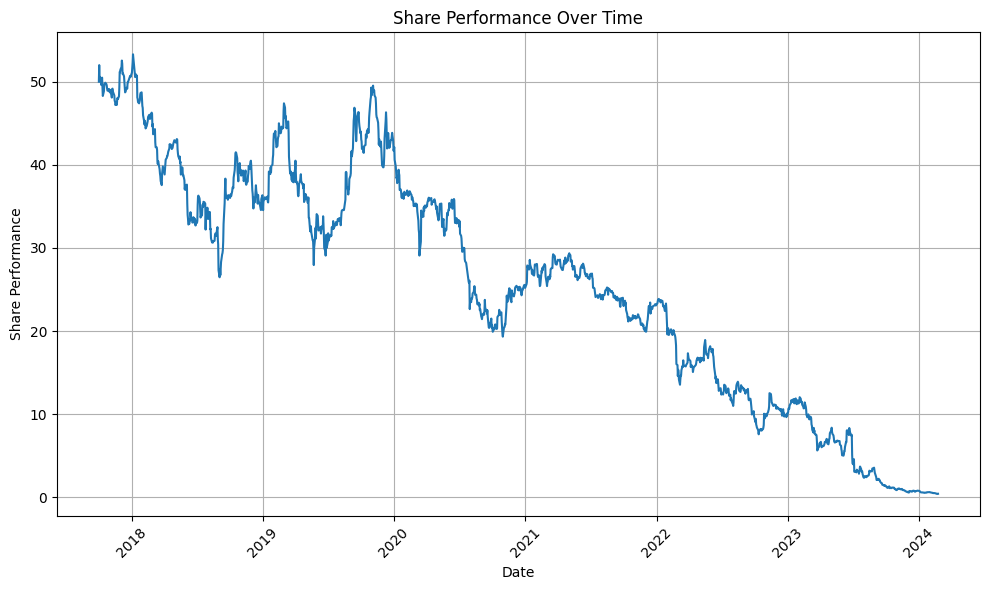

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(share_performance.index, share_performance['Share Performance'], linestyle='-')
plt.title('Share Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Share Performance')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
holder = "CITADEL ADVISORS EUROPE LIMITED"
emitter =  "ELIS"
ticker = ticker_dic.get(emitter, False)

short_net_positions, start_date = visualiser_investissment(holder,emitter, df_sorted,visu = False)
share_performance = get_share(start_date, ticker)
#print(short_net_positions)

print("- - - - - - - - - -")

score_calculator(short_net_positions, share_performance)

[*********************100%%**********************]  1 of 1 completed

- - - - - - - - - -


(                 Net short position in %      Score
 Days from start                                    
 0                                   0.55   0.000000
 2                                   0.63  -3.988363
 14                                  0.73 -18.737014
 37                                  0.79 -18.612374
 48                                  0.92 -36.705438
 55                                  1.00 -35.708355
 62                                  0.99 -35.396765
 65                                  1.02 -36.144583
 71                                  0.99 -33.153304
 79                                  1.02 -35.272119
 85                                  0.94 -16.992097
 105                                 1.01 -22.081425
 110                                 0.99 -18.009969
 118                                 1.02 -16.078107
 126                                 1.13 -38.928105
 134                                 1.03 -42.251741
 138                                 0.95 -20.

In [53]:
score_calculator(short_net_positions, share_performance, 90)

(                 Net short position in %      Score
 Days from start                                    
 0                                   0.55   0.000000
 2                                   0.63  -3.988363
 14                                  0.73 -18.737014
 37                                  0.79 -18.612374
 48                                  0.92 -36.705438
 55                                  1.00 -35.708355
 62                                  0.99 -35.396765
 65                                  1.02 -36.144583
 71                                  0.99 -33.153304
 79                                  1.02 -35.272119
 85                                  0.94 -16.992097
 105                                 1.01 -22.081425
 110                                 0.99 -18.009969
 118                                 1.02 -16.078107
 126                                 1.13 -38.928105
 134                                 1.03 -42.251741
 138                                 0.95 -20.

In [54]:
holder = "MILLENNIUM CAPITAL PARTNERS LLP"
emitter =  "REXEL"
ticker = ticker_dic.get(emitter, False)

short_net_positions, start_date = visualiser_investissment(holder,emitter, df_sorted,visu = False)
share_performance = get_share(start_date, ticker)
#print(short_net_positions)

print("- - - - - - - - - -")

score_calculator(short_net_positions, share_performance)

[*********************100%%**********************]  1 of 1 completed

- - - - - - - - - -


(                 Net short position in %      Score
 Days from start                                    
 0                                   0.51   0.000000
 2                                   0.64   4.895775
 7                                   0.58   0.247997
 10                                  0.68   1.687023
 14                                  0.70  -0.272513
 ...                                  ...        ...
 723                                 1.63 -56.593835
 728                                 1.55 -53.654530
 731                                 1.63 -54.536323
 736                                 1.81 -63.133772
 744                                 1.75 -63.133772
 
 [152 rows x 2 columns],
 -0.06313377153861333)

In [57]:
score_calculator(short_net_positions, share_performance, 90)

(                 Net short position in %      Score
 Days from start                                    
 0                                   0.51   0.000000
 2                                   0.64   4.895775
 7                                   0.58   0.247997
 10                                  0.68   1.687023
 14                                  0.70  -0.272513
 ...                                  ...        ...
 723                                 1.63 -56.593835
 728                                 1.55 -53.654530
 731                                 1.63 -54.536323
 736                                 1.81 -63.133772
 744                                 1.75 -63.133772
 
 [152 rows x 2 columns],
 -0.06313377153861333)